In [1]:
# Make full use of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import time
import pickle
import random
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import gensim
import pandas as pd
import datetime
from tensorboardX import SummaryWriter
random.seed()

In [3]:
os.uname()[1]

'dongwenjian-ThinkPad-E460'

In [4]:
computer_name = os.uname()[1]
if computer_name == "wenjian-desktop":
    fr_dataset_volume = "3k"
    img_dir = "/home/wenjian/Internship/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/home/wenjian/Internship/data/flickr30kentities/flickr30k-feats-otani/bottom-up-feats/"
    #features_dir = "/home/wenjian/Internship/GitHubCloned/DDPN/data/flickr30k/features/bottom-up-feats-resnet101/"

    #train_image_list_filepath = "/home/wenjian/Internship/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    #train_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_1000-images.csv"
    train_triple_filepath = f"/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_{fr_dataset_volume}-images.csv"
    train_triple_filepath_en = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/val_queries_fr.csv"
    test_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/test_2016_flickr_queries_fr.csv"
    
    xml_dirpath = "/home/wenjian/Internship/data/flickr30kentities/annotations/Annotations/"

    project_root = "/home/wenjian/Internship/DDPN_transfer/"
    
    english_pretrained_model_path = "/home/wenjian/Internship/DDPN_transfer/pretrained-models/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar"
    specific_dictionary_file = "/home/wenjian/Internship/data/word_allignment/lex.e2f"  # The file name is e2f, but in fact it is f2e
    general_dictionary_file = f"/home/wenjian/Internship/DDPN_transfer/dictionary/Fr-En-GoogleTrans_dictionary{fr_dataset_volume}.txt"
    
elif computer_name == "apas":
    img_dir = "/home/wenjian/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/home/wenjian/data/flickr30kentities/bottom-up-feats/"
    
    #train_image_list_filepath = "/home/wenjian/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    #train_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/train_queries_fr_auto_3000.csv"
    train_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_1000-images.csv"
    train_triple_filepath_en = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/home/wenjian/data/flickr30kentities/queries_extracted/val_queries_fr.csv"

    xml_dirpath = "/home/wenjian/data/flickr30kentities/annotations/Annotations/"

    project_root = None
    
    english_pretrained_model_path = None
    dictionary_file = None
    general_dictionary_file = None
    
elif computer_name == "dongwenjian-ThinkPad-E460":
    fr_dataset_volume = "5k"
    img_dir = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/flickr30k-images/"  # For visualization
    
    features_dir = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/flickr30k-feats-otani/bottom-up-feats/"
    #features_dir = "/home/wenjian/Internship/GitHubCloned/DDPN/data/flickr30k/features/bottom-up-feats-resnet101/"

    #train_image_list_filepath = "/home/wenjian/Internship/data/flickr30kentities/Multi30k/task1/image_splits/train.txt"
    #train_triple_filepath = "/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries_fr_1000-images.csv"
    train_triple_filepath = f"/media/dongwenjian/SSDBACKUP/newly_added/data/flickr30kentities/queries_extracted/train_queries_fr_{fr_dataset_volume}-images.csv"
    train_triple_filepath_en = "/media/dongwenjian/SSDBACKUP/newly_added/data/flickr30kentities/queries_extracted/train_queries.csv"

    val_triple_filepath = "/media/dongwenjian/SSDBACKUP/newly_added/data/flickr30kentities/queries_extracted/val_queries_fr.csv"
    test_triple_filepath = "/media/dongwenjian/SSDBACKUP/newly_added/data/flickr30kentities/queries_extracted/test_2016_flickr_queries_fr.csv"
    
    xml_dirpath = "/media/dongwenjian/SSDBACKUP/Internship/data/flickr30kentities/annotations/Annotations/"

    project_root = "/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/"
    
    english_pretrained_model_path = "/media/dongwenjian/SSDBACKUP/Internship/DDPN_transfer/pretrained-models/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar"
    specific_dictionary_file = "/media/dongwenjian/SSDBACKUP/Internship/data/word_allignment/lex.e2f"  # The file name is e2f, but in fact it is f2e
    general_dictionary_file = f"/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/dictionary/Fr-En-GoogleTrans_dictionary{fr_dataset_volume}.txt"
    
else:
    raise Exception("Failed to initialize paths: computer not recognized")
print(computer_name)

dongwenjian-ThinkPad-E460


In [5]:
torch.cuda.device_count()

0

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")


In [7]:
class CFG:
    def __init__(self):
        # cfg_path for future use
        self.xml_dirpath = xml_dirpath
        self.triple_filepaths = {'train': train_triple_filepath,
                                 'val': val_triple_filepath,
                                 'test': test_triple_filepath
                                }
        self.RPN_TOPN = 100
        
        # Configure for network
        self.WORD_EMB_SIZE = 300
        self.RNN_DIM = 1024
        self.VISUAL_FEATURES = 2048  # For resnet
        self.SPATIAL_FEATURES = 5
        self.SOFTLABEL_THRESHOLD = 0.5 # 0.5 in paper
        self.GAMMA = 1
        self.DELTA = 1
        self.STEMMING = False
        self.epsilon = 1e-7
        self.dropout_rate = 0.5
        self.lr_decay_rate = 0.7
        self.initial_lr = 0.001
        self.use_pretrained_word_embedding = None  # candidate: None, "GloVe"
        #self.use_pretrained_model = False
        self.regression_loss = False
        self.transfer_learning = True
        
         
        # At the beginning those paths are not wrapped and they exist as global variables. 
        # Then in order to wrap the training, validation and test process into functions, we need to avoid global variables. 
        # Thus we begin to wrap more things into CFG.
        # It should be noticed that, the part before training are not adapted yet, thus for the following variables they may still use the original global variables
        
        # The paths 
        self.fr_dataset_volume = fr_dataset_volume
        self.img_dir = img_dir
        self.features_dir = features_dir

        self.train_triple_filepath_en = train_triple_filepath_en
        
        self.project_root = project_root 
        
        self.english_pretrained_model_path = english_pretrained_model_path
        self.general_dictionary_file = general_dictionary_file
        self.specific_dictionary_file = specific_dictionary_file
        
        # The file names to store the training process
        self.pth_filename = None
        self.checkpoint_filename_base = None
        self.process_filename = None
        self.pytorch_model_save_path = None
        self.pytorch_result_save_path = None
        self.pytorch_checkpoint_save_path = None
        self.output_root = None
        self.output_dir_name = None
        self.output_dir = None
        self.log_dir = None
        # Here we create them as None just as a reminder that those variables will be involved later. 
        
cfg = CFG()

In [8]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) \n[GCC 7.3.0]'

In [8]:

# train_imageID_list = []
# with open(train_image_list_filepath, 'r') as f:
#     l = f.readline()
#     while l :
#         train_imageID_list.append(l.split('.')[0])
#         l = f.readline()
# print(len(train_imageID_list))
# print(train_imageID_list[0])

## Establish vocabulary dictionary from training set: French   

In [9]:
train_df = pd.read_csv(train_triple_filepath)
#stemmer = SnowballStemmer("english")
corpus_list = train_df["entity_content"].values.tolist()
corpus_list = ['EMPTYWORDTOKEN', 'UNKNOWNWORD'] + corpus_list  # 'EMPTYWORDTOKEN' is the token for empty word. It is needed because the input data for word embedding layer require padding. 

if cfg.STEMMING:
    corpus = [[stemmer.stem(w) for w in word_tokenize(q, language="french")] for q in corpus_list]
else: 
    corpus = [[w.lower() for w in word_tokenize(q, language="french")] for q in corpus_list]
# corpus is a list of list of string

training_corpus_dct = gensim.corpora.Dictionary(corpus)

In [10]:
corpus_list

['EMPTYWORDTOKEN',
 'UNKNOWNWORD',
 'deux jeunes hommes blancs',
 'de buissons',
 'plusieurs hommes',
 'casque',
 'un système de poulies géant',
 'une petite fille',
 'une maisonnette en bois',
 'un homme',
 'une chemise bleue',
 'une échelle',
 'une fenêtre',
 'deux hommes',
 'fourneaux',
 'un homme',
 'vert',
 'une guitare',
 'un autre homme',
 'sa chemise',
 'un homme',
 'un ours en peluche',
 'une fille branchée',
 'son portable',
 'la rue',
 'une femme',
 'un gros sac',
 'une porte',
 'des garçons',
 'des barres',
 'une classe de ballet , composée de cinq filles',
 'quatre gars',
 'des chapeaux',
 "haut d' un escalier",
 'un chien noir',
 'un chien à tâches',
 'un homme',
 'uniforme orange',
 'un tracteur vert',
 'plusieurs femmes',
 'une femme',
 'un haut noir',
 'des lunettes',
 'sucre',
 'un bundt cake',
 'une petite fille',
 'un grand arc-en-ciel peint',
 'un homme',
 'un banc [',
 'un chien blanc',
 'cinq personnes',
 'cercle',
 'leurs instruments',
 'un groupe de femmes âgée

In [11]:
len(corpus) 

13836

In [12]:
corpus[0]

['emptywordtoken']

In [13]:
corpus[1]

['unknownword']

In [14]:
training_corpus_dct.__dict__

{'token2id': {'emptywordtoken': 0,
  'unknownword': 1,
  'blancs': 2,
  'deux': 3,
  'hommes': 4,
  'jeunes': 5,
  'buissons': 6,
  'de': 7,
  'plusieurs': 8,
  'casque': 9,
  'géant': 10,
  'poulies': 11,
  'système': 12,
  'un': 13,
  'fille': 14,
  'petite': 15,
  'une': 16,
  'bois': 17,
  'en': 18,
  'maisonnette': 19,
  'homme': 20,
  'bleue': 21,
  'chemise': 22,
  'échelle': 23,
  'fenêtre': 24,
  'fourneaux': 25,
  'vert': 26,
  'guitare': 27,
  'autre': 28,
  'sa': 29,
  'ours': 30,
  'peluche': 31,
  'branchée': 32,
  'portable': 33,
  'son': 34,
  'la': 35,
  'rue': 36,
  'femme': 37,
  'gros': 38,
  'sac': 39,
  'porte': 40,
  'des': 41,
  'garçons': 42,
  'barres': 43,
  ',': 44,
  'ballet': 45,
  'cinq': 46,
  'classe': 47,
  'composée': 48,
  'filles': 49,
  'gars': 50,
  'quatre': 51,
  'chapeaux': 52,
  "'": 53,
  'd': 54,
  'escalier': 55,
  'haut': 56,
  'chien': 57,
  'noir': 58,
  'tâches': 59,
  'à': 60,
  'orange': 61,
  'uniforme': 62,
  'tracteur': 63,
  'femm

In [15]:
len(training_corpus_dct.token2id) 
# It should be kept in mind that the real number of the different tokens in the dataset is len(training_corpus_dct.token2id)-2
# because in training_corpus_dct we added 'emptywordtoken' and 'unknownword'.
# But in the codes below we will use len(training_corpus_dct.token2id) directly as vocabulary size, 
# as 'emptywordtoken' and 'unknownword' also have their embeddings in the embedding matrix. 

3112

In [18]:
training_corpus_dct.dfs

{0: 1,
 1: 1,
 3: 650,
 5: 111,
 4: 295,
 2: 31,
 7: 1335,
 6: 5,
 8: 72,
 9: 44,
 13: 5419,
 12: 1,
 11: 1,
 10: 4,
 16: 2983,
 15: 127,
 14: 332,
 19: 1,
 18: 182,
 17: 56,
 20: 1382,
 22: 178,
 21: 88,
 23: 8,
 24: 30,
 25: 1,
 26: 89,
 27: 82,
 28: 115,
 29: 125,
 30: 5,
 31: 10,
 32: 1,
 34: 178,
 33: 23,
 35: 669,
 36: 126,
 37: 704,
 38: 44,
 39: 58,
 40: 29,
 41: 961,
 42: 67,
 43: 3,
 47: 7,
 45: 1,
 44: 25,
 48: 1,
 46: 35,
 49: 80,
 51: 59,
 50: 46,
 52: 13,
 56: 23,
 54: 447,
 53: 849,
 55: 10,
 57: 405,
 58: 264,
 60: 195,
 59: 2,
 62: 17,
 61: 65,
 63: 8,
 64: 147,
 65: 98,
 66: 1,
 67: 1,
 68: 1,
 70: 64,
 69: 3,
 71: 5,
 73: 55,
 72: 228,
 74: 224,
 75: 275,
 76: 1,
 78: 28,
 77: 8,
 79: 268,
 80: 8,
 81: 1,
 82: 18,
 83: 4,
 84: 34,
 85: 13,
 86: 3,
 89: 3,
 87: 71,
 88: 211,
 90: 38,
 91: 165,
 94: 167,
 93: 2,
 92: 2,
 95: 385,
 96: 44,
 97: 30,
 98: 4,
 99: 8,
 100: 30,
 101: 138,
 103: 36,
 102: 156,
 105: 67,
 104: 1,
 106: 10,
 107: 3,
 108: 25,
 109: 50,
 110: 2

In [19]:
freq = list(training_corpus_dct.dfs.values())
print(freq)

[1, 1, 650, 111, 295, 31, 1335, 5, 72, 44, 5419, 1, 1, 4, 2983, 127, 332, 1, 182, 56, 1382, 178, 88, 8, 30, 1, 89, 82, 115, 125, 5, 10, 1, 178, 23, 669, 126, 704, 44, 58, 29, 961, 67, 3, 7, 1, 25, 1, 35, 80, 59, 46, 13, 23, 447, 849, 10, 405, 264, 195, 2, 17, 65, 8, 147, 98, 1, 1, 1, 64, 3, 5, 55, 228, 224, 275, 1, 28, 8, 268, 8, 1, 18, 4, 34, 13, 3, 3, 71, 211, 38, 165, 167, 2, 2, 385, 44, 30, 4, 8, 30, 138, 36, 156, 67, 1, 10, 3, 25, 50, 205, 259, 341, 105, 71, 168, 109, 1, 14, 16, 38, 15, 6, 1, 1, 3, 10, 71, 14, 93, 7, 405, 10, 5, 95, 4, 7, 3, 38, 43, 4, 1, 3, 12, 2, 7, 10, 3, 1, 384, 1, 2, 15, 80, 52, 33, 5, 8, 10, 1, 177, 77, 169, 16, 15, 4, 57, 18, 3, 52, 52, 1, 14, 8, 2, 1, 1, 1, 22, 84, 1, 251, 1, 6, 3, 30, 30, 1, 2, 4, 12, 1, 43, 1, 43, 4, 2, 16, 4, 7, 15, 9, 88, 5, 52, 62, 1, 33, 13, 15, 1, 1, 10, 36, 11, 24, 1, 6, 3, 7, 28, 32, 76, 57, 12, 34, 16, 2, 11, 8, 2, 2, 1, 1, 31, 6, 1, 16, 5, 5, 3, 1, 4, 170, 6, 5, 10, 14, 18, 4, 8, 12, 15, 12, 14, 13, 21, 6, 5, 6, 1, 15, 12, 65, 6

In [20]:
torch.sum(torch.tensor(freq) >= 3)

tensor(1059)

In [21]:
torch.sum(torch.tensor(freq) >= 5)

tensor(667)

In [9]:
corpus_list

['EMPTYWORDTOKEN',
 'UNKNOWNWORD',
 'deux jeunes hommes blancs',
 'de buissons',
 'plusieurs hommes',
 'casque',
 'un système de poulies géant',
 'une petite fille',
 'une maisonnette en bois',
 'un homme',
 'une chemise bleue',
 'une échelle',
 'une fenêtre',
 'deux hommes',
 'fourneaux',
 'un homme',
 'vert',
 'une guitare',
 'un autre homme',
 'sa chemise',
 'un homme',
 'un ours en peluche',
 'une fille branchée',
 'son portable',
 'la rue',
 'une femme',
 'un gros sac',
 'une porte',
 'des garçons',
 'des barres',
 'une classe de ballet , composée de cinq filles',
 'quatre gars',
 'des chapeaux',
 "haut d' un escalier",
 'un chien noir',
 'un chien à tâches',
 'un homme',
 'uniforme orange',
 'un tracteur vert',
 'plusieurs femmes',
 'une femme',
 'un haut noir',
 'des lunettes',
 'sucre',
 'un bundt cake',
 'une petite fille',
 'un grand arc-en-ciel peint',
 'un homme',
 'un banc [',
 'un chien blanc',
 'cinq personnes',
 'cercle',
 'leurs instruments',
 'un groupe de femmes âgée

## Dataset statistics

In [26]:
val_df = pd.read_csv(val_triple_filepath)

In [33]:
corpus_list = val_df["entity_content"].values.tolist() 
corpus_list

["un groupe d' hommes",
 'du coton',
 'un camion',
 'un homme',
 'un canapé',
 'un garçon',
 'un casque',
 'deux hommes',
 'une tente de pêche',
 'un lac gelé',
 'un homme chauve',
 'un gilet de sauvetage rouge',
 'une femme',
 'manteau rouge',
 'un sac à main bleuté',
 'origine asiatique',
 'un chien brun',
 'le chien noir',
 'un jeune garçon',
 'un maillot des giants',
 'une batte de base-ball',
 'une balle qui arrive',
 'un homme',
 'un bureau encombré',
 'le téléphone',
 'une femme souriante',
 'un débardeur pêche',
 'un vtt',
 'un jeune enfant',
 'des rochers tranchants',
 'une personne',
 'une motoneige',
 'trois jeunes enfants',
 'un baril bleu et blanc',
 'une femme',
 'son stand de fleurs séchées',
 'une femme',
 'son violon',
 'trois personnes',
 'deux motocross',
 'un quad',
 "l' herbe brunie",
 'un homme à moitié nu',
 'son fauteuil dehors',
 'un groupe de personnes',
 'une cabane',
 'une jeune femme',
 'des tapis',
 'trois filles',
 'des grimaces',
 "l' une",
 'un coup',
 

In [34]:
corpus = [[w.lower() for w in word_tokenize(q, language="french")] for q in corpus_list]

In [36]:
val_corpus_dct = gensim.corpora.Dictionary(corpus)

In [37]:
len(corpus)

2756

In [38]:
len(val_corpus_dct.token2id)

1266

In [39]:
freq = list(val_corpus_dct.dfs.values())
torch.sum(torch.tensor(freq) >= 3)

tensor(309)

In [40]:
test_df = pd.read_csv(test_triple_filepath)
corpus_list = test_df["entity_content"].values.tolist() 
corpus_list

['un homme',
 'un chapeau orange',
 'un terrier de boston',
 "l' herbe verdoyante",
 'une clôture blanche',
 'une fille',
 'karaté',
 'un bâton',
 'cinq personnes',
 "des vestes d' hiver",
 'des casques',
 'la neige',
 'des motoneiges',
 'des gens',
 "le toit d' une maison",
 'un homme',
 'tenue claire photographie [',
 'des costumes sombres',
 'des chapeaux',
 'une femme',
 'une robe bustier',
 'un groupe de personnes',
 'un igloo',
 'un garçon',
 'uniforme rouge',
 'marbre',
 'le receveur',
 'tenue bleue',
 'un gars',
 'un bâtiment',
 'un homme',
 'gilet',
 'une chaise',
 'des magazines',
 'une mère',
 'son jeune fils',
 'des hommes',
 'un joueur',
 'le ballon',
 'les mains',
 'une femme',
 'un plat de nourriture',
 'un homme',
 'une table [',
 'un outil',
 'trois personnes',
 'une fille',
 'une robe en jean',
 "une poutre d' équilibre surélevée",
 'une blonde',
 'la main',
 'un gars',
 'le sable',
 'une femme',
 'un pull gris',
 'une casquette noire',
 'la personne',
 'maillot rayé'

In [41]:
corpus = [[w.lower() for w in word_tokenize(q, language="french")] for q in corpus_list]
test_corpus_dct = gensim.corpora.Dictionary(corpus)

In [42]:
len(corpus)

2789

In [43]:
len(test_corpus_dct.token2id)

1229

In [44]:
freq = list(test_corpus_dct.dfs.values())
torch.sum(torch.tensor(freq) >= 3)

tensor(330)

In [ ]:
# For English
general_df = pd.read_csv(train_triple_filepath_en)
corpus_list_en = general_df["entity_content"].values.tolist() 
corpus_list_en

In [ ]:
corpus_en = [[w.lower() for w in word_tokenize(q)] for q in corpus_list_en]
general_corpus_dct_en = gensim.corpora.Dictionary(corpus_en)

## Establish vocabulary dictionary from training set: English

In [16]:
train_df_en = pd.read_csv(train_triple_filepath_en)
corpus_list_en = train_df_en["entity_content"].values.tolist()
corpus_list_en = ['EMPTYWORDTOKEN', 'UNKNOWNWORD'] + corpus_list_en  # 'EMPTYWORDTOKEN' is the token for empty word. It is needed because the input data for word embedding layer require padding. 
if cfg.STEMMING:
    corpus_en = [[stemmer.stem(w) for w in word_tokenize(q)] for q in corpus_list_en]
else: 
    corpus_en = [[w.lower() for w in word_tokenize(q)] for q in corpus_list_en]
# corpus is a list of list of string

training_corpus_dct_en = gensim.corpora.Dictionary(corpus_en)
training_corpus_dct_en.__dict__

{'token2id': {'emptywordtoken': 0,
  'unknownword': 1,
  'guys': 2,
  'two': 3,
  'young': 4,
  'hair': 5,
  'shaggy': 6,
  'hands': 7,
  'their': 8,
  ',': 9,
  'males': 10,
  'white': 11,
  'bushes': 12,
  'many': 13,
  'men': 14,
  'green': 15,
  'shirts': 16,
  'a': 17,
  'man': 18,
  'blue': 19,
  'shirt': 20,
  'friends': 21,
  'several': 22,
  'hard': 23,
  'hats': 24,
  'giant': 25,
  'pulley': 26,
  'system': 27,
  'workers': 28,
  'equipment': 29,
  'of': 30,
  'piece': 31,
  'machine': 32,
  'four': 33,
  'structure': 34,
  'tall': 35,
  'three': 36,
  'large': 37,
  'rig': 38,
  'child': 39,
  'dress': 40,
  'pink': 41,
  'set': 42,
  'stairs': 43,
  'an': 44,
  'entry': 45,
  'way': 46,
  'girl': 47,
  'little': 48,
  'the': 49,
  'her': 50,
  'playhouse': 51,
  'wooden': 52,
  'someone': 53,
  'hat': 54,
  'stair': 55,
  'window': 56,
  'ladder': 57,
  'building': 58,
  'jeans': 59,
  'windows': 60,
  'one': 61,
  'gray': 62,
  'black': 63,
  'stove': 64,
  'guy': 65,
  '

In [18]:
len(training_corpus_dct_en.token2id)

14384

In [52]:
training_corpus_dct_en.dfs

{0: 1,
 1: 1,
 3: 19353,
 4: 11942,
 2: 601,
 6: 45,
 5: 1995,
 8: 2776,
 7: 1330,
 9: 1322,
 11: 11620,
 10: 233,
 13: 1110,
 12: 81,
 14: 8629,
 15: 4470,
 16: 839,
 17: 214432,
 18: 38854,
 19: 10014,
 20: 11839,
 21: 364,
 22: 1881,
 23: 449,
 24: 763,
 25: 184,
 26: 18,
 27: 23,
 28: 1015,
 31: 643,
 30: 20460,
 29: 402,
 32: 483,
 33: 1972,
 35: 381,
 34: 296,
 36: 5163,
 37: 3988,
 38: 9,
 39: 4557,
 41: 2555,
 40: 1963,
 42: 224,
 43: 401,
 44: 11746,
 45: 8,
 46: 40,
 48: 4230,
 47: 8601,
 49: 34427,
 50: 4901,
 51: 16,
 52: 887,
 53: 626,
 54: 3645,
 55: 27,
 56: 853,
 57: 298,
 58: 2436,
 59: 1741,
 60: 158,
 61: 5034,
 62: 1876,
 63: 11030,
 64: 83,
 65: 1332,
 66: 1363,
 67: 202,
 68: 15591,
 69: 1816,
 70: 2305,
 71: 8939,
 73: 1026,
 72: 490,
 75: 2315,
 74: 1415,
 76: 1192,
 77: 1787,
 78: 937,
 81: 177,
 79: 254,
 80: 40,
 82: 2,
 83: 2,
 84: 951,
 85: 52,
 86: 679,
 88: 152,
 87: 352,
 89: 9,
 90: 4224,
 91: 438,
 92: 64,
 93: 15,
 94: 506,
 95: 16,
 96: 20165,
 97: 1

In [ ]:
# This is to test some different strategies to handle words. Normally it is not needed to be run
train_df_en2 = pd.read_csv(train_triple_filepath_en)
corpus_list_en2 = train_df_en2["entity_content"].values.tolist()
corpus_list_en2 = ['EMPTYWORDTOKEN', 'UNKNOWNWORD'] + corpus_list_en2  # 'EMPTYWORDTOKEN' is the token for empty word. It is needed because the input data for word embedding layer require padding. 
if cfg.STEMMING:
    corpus_en = [[stemmer.stem(w) for w in word_tokenize(q)] for q in corpus_list_en]
else: 
    corpus_en2 = [[w.lower() for w in word_tokenize(q, language="english")] for q in corpus_list_en2]
# corpus is a list of list of string

training_corpus_dct_en2 = gensim.corpora.Dictionary(corpus_en2)
training_corpus_dct_en2.__dict__

In [ ]:
training_corpus_dct_en.token2id == training_corpus_dct_en2.token2id

### sort

In [24]:
def vocab_list_sorted_by_freq(dict_index_freq):
    freq_list = [(k, v) for k, v in dict_index_freq.items()]
    freq_list.sort(key=lambda tup: tup[1], reverse=True)
    return freq_list # Return: a list of tuple. meaning: (index_of_word, frequency)

In [46]:
freq_list_fr = vocab_list_sorted_by_freq(training_corpus_dct.dfs)
freq_list_en = vocab_list_sorted_by_freq(training_corpus_dct_en.dfs)

In [47]:
freq_list_en

[(17, 214432),
 (18, 38854),
 (49, 34427),
 (30, 20460),
 (96, 20165),
 (3, 19353),
 (68, 15591),
 (4, 11942),
 (20, 11839),
 (44, 11746),
 (11, 11620),
 (63, 11030),
 (19, 10014),
 (71, 8939),
 (239, 8808),
 (14, 8629),
 (47, 8601),
 (223, 8383),
 (129, 8099),
 (160, 7095),
 (186, 5318),
 (36, 5163),
 (61, 5034),
 (50, 4901),
 (158, 4853),
 (39, 4557),
 (15, 4470),
 (407, 4264),
 (48, 4230),
 (90, 4224),
 (208, 4008),
 (37, 3988),
 (277, 3976),
 (130, 3951),
 (222, 3927),
 (54, 3645),
 (286, 3206),
 (175, 3140),
 (171, 3043),
 (8, 2776),
 (152, 2745),
 (41, 2555),
 (215, 2549),
 (157, 2529),
 (58, 2436),
 (296, 2422),
 (75, 2315),
 (70, 2305),
 (116, 2291),
 (317, 2172),
 (136, 2080),
 (1337, 2074),
 (329, 2047),
 (5, 1995),
 (33, 1972),
 (40, 1963),
 (97, 1961),
 (125, 1935),
 (22, 1881),
 (247, 1880),
 (62, 1876),
 (166, 1870),
 (464, 1848),
 (69, 1816),
 (259, 1795),
 (77, 1787),
 (59, 1741),
 (176, 1720),
 (313, 1719),
 (442, 1697),
 (472, 1653),
 (410, 1579),
 (121, 1564),
 (185,

In [48]:
len(freq_list_fr)

3112

In [20]:
freq_comparison = []
for i in range(len(freq_list_fr)):
    fr_word = training_corpus_dct[freq_list_fr[i][0]]
    en_word = training_corpus_dct_en[freq_list_en[i][0]]
    freq_comparison.append((fr_word, en_word))

1k sentences

3k sentences

In [21]:
freq_comparison = []
for i in range(len(freq_list_fr)):
    fr_word = training_corpus_dct[freq_list_fr[i][0]]
    en_word = training_corpus_dct_en[freq_list_en[i][0]]
    freq_comparison.append((fr_word, en_word))

In [22]:
freq_comparison

[('un', 'a'),
 ('une', 'man'),
 ('homme', 'the'),
 ('de', 'of'),
 ('des', 'woman'),
 ("'", 'two'),
 ('femme', 'people'),
 ('la', 'young'),
 ('deux', 'shirt'),
 ('d', 'an'),
 ('chien', 'white'),
 ('l', 'black'),
 ('le', 'blue'),
 ('garçon', 'his'),
 ('jeune', 'red'),
 ('fille', 'men'),
 ('hommes', 'girl'),
 ('personnes', 'boy'),
 ('groupe', 'dog'),
 ('noir', 'group'),
 ('rouge', 'and'),
 ('les', 'three'),
 ('[', 'one'),
 ('blanc', 'her'),
 ('gens', 'women'),
 ('enfant', 'child'),
 ('à', 'green'),
 ('en', 'water'),
 ('chemise', 'little'),
 ('son', 'street'),
 ('trois', 'person'),
 ('t-shirt', 'large'),
 ('eau', 'yellow'),
 ('et', 'brown'),
 ('petit', 'children'),
 ('enfants', 'hat'),
 ('bleu', 'ball'),
 ('femmes', 'small'),
 ('personne', 'jacket'),
 ('petite', 'their'),
 ('rue', 'orange'),
 ('sa', 'pink'),
 ('autre', 'crowd'),
 ('brun', 'some'),
 ('jeunes', 'building'),
 ('jaune', 'table'),
 ('veste', 'another'),
 ('lunettes', 'other'),
 ('cheveux', 'girls'),
 ('chapeau', 'bike'),
 ('bla

In [28]:
for i in range(20):
    print(freq_comparison[i][1])

a
man
the
of
woman
two
people
young
shirt
an
white
black
blue
his
red
men
girl
boy
dog
group


### Word look up

In [35]:
training_corpus_dct.token2id["punching-ball"]

KeyError: 'punching-ball'

In [48]:
training_corpus_dct.token2id["monospace"]

KeyError: 'monospace'

In [39]:
training_corpus_dct.token2id["parapluies"]

KeyError: 'parapluies'

## GloVe Word embedding

In [10]:
import torchtext
import pandas as pd
from nltk.tokenize import word_tokenize

In [11]:
glove = torchtext.vocab.GloVe(name='6B', dim=300)

Noted that in GloVe, there is no unknown word token, nor empty word token. 
Here we use index=1, which is '.' as empty word token

In [12]:
train_df = pd.read_csv("/home/wenjian/Internship/data/flickr30kentities/queries_extracted/train_queries.csv")

In [13]:
corpus_list = train_df["entity_content"].values.tolist()

In [14]:
if cfg.STEMMING:
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")
    corpus = [[stemmer.stem(w) for w in word_tokenize(q)] for q in corpus_list]
else: 
    corpus = [[w.lower() for w in word_tokenize(q)] for q in corpus_list]

In [15]:
corpus

[['two', 'young', 'guys'],
 ['shaggy', 'hair'],
 ['their', 'hands'],
 ['two', 'young', ',', 'white', 'males'],
 ['many', 'bushes'],
 ['two', 'men'],
 ['green', 'shirts'],
 ['a', 'man'],
 ['a', 'blue', 'shirt'],
 ['two', 'friends'],
 ['several', 'men'],
 ['hard', 'hats'],
 ['a', 'giant', 'pulley', 'system'],
 ['workers'],
 ['a', 'piece', 'of', 'equipment'],
 ['two', 'men'],
 ['a', 'machine'],
 ['hard', 'hats'],
 ['four', 'men'],
 ['a', 'tall', 'structure'],
 ['three', 'men'],
 ['a', 'large', 'rig'],
 ['a', 'child'],
 ['a', 'pink', 'dress'],
 ['a', 'set', 'of', 'stairs'],
 ['an', 'entry', 'way'],
 ['a', 'little', 'girl'],
 ['a', 'pink', 'dress'],
 ['a', 'little', 'girl'],
 ['the', 'stairs'],
 ['her', 'playhouse'],
 ['a', 'little', 'girl'],
 ['a', 'wooden', 'playhouse'],
 ['a', 'girl'],
 ['someone'],
 ['a', 'blue', 'shirt'],
 ['hat'],
 ['stair'],
 ['a', 'window'],
 ['a', 'man'],
 ['a', 'blue', 'shirt'],
 ['a', 'ladder'],
 ['a', 'window'],
 ['a', 'man'],
 ['a', 'ladder'],
 ['the', 'window'

## Data Generation

In [17]:
from torch.utils import data
import pandas as pd
import xml.etree.ElementTree as ET

class DDPNDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, cfg, phase):
        'Initialization'
        #self.labels = labels
        #self.list_IDs = list_IDs
        self.cfg = cfg
        self.phase = phase
        self.df_triple = pd.read_csv(self.cfg.triple_filepaths[self.phase])  # Triple means (image, ground_truth_bounding_box, query)
        

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df_triple.index)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        imageID = str(self.df_triple.iloc[index]["imgId"])
        entityID = str(self.df_triple.iloc[index]["entityId"])
        
        # Load data and get label
        # X = torch.load('data/' + ID + '.pt')
        # X should be all the inputs, include visual features and text query
        zf = np.load(features_dir+imageID+'.jpg.npz')
        num_bbox = zf['num_bbox']
        visual_feat = zf['x']  # visual_feat's shape here is supposed to be (2048, num_bbox) for resnet, (4096, num_bbox) for vgg16
        visual_feat = np.transpose(visual_feat) # now (num_bbox, 2048) for resnet, (num_bbox, 4096) for vgg16
        spatial_feat = zf['bbox'] # spatial_feat's shape here is supposed to be (num_bbox, 4)
        x1 = spatial_feat[:,0]
        y1 = spatial_feat[:,1]
        x2 = spatial_feat[:,2]
        y2 = spatial_feat[:,3]
        image_w = zf['image_w']
        image_h = zf['image_h']
        spatial_feat = np.column_stack((x1/image_w, y1/image_h, x2/image_w, y2/image_h, (x2-x1)*(y2-y1)/(image_w*image_h)))
        
        # Concatenate visual features and spatial features
        X = np.column_stack((visual_feat, spatial_feat))
        
        # If there are fewer than self.cfg.RPN_TOPN=100 proposals, add 0 rows below
        for i in range(X.shape[0], self.cfg.RPN_TOPN):
            zero_row = np.zeros((1,X.shape[1]))
            X = np.vstack((X, zero_row))
        # Convert numpy array to torch tensor 
        X = torch.from_numpy(X)
        X = X.float()
        
        query = self.df_triple.iloc[index]["entity_content"]
        
        # Get ground truth bounding box
        gt_bbox = self._get_bounding_box(imageID, entityID) # gt_bbox is a triple in format (x1, y1, x2, y2)
        # Get the bounding box boundary regard as image size
        gt_bbox[0] /= float(image_w)
        gt_bbox[2] /= float(image_w)
        gt_bbox[1] /= float(image_h)
        gt_bbox[3] /= float(image_h)
        # Convert list to torch tensor
        gt_bbox = torch.tensor(gt_bbox) 
        
        additional_info = (imageID, entityID, image_w, image_h) # those info are not directly used in training, but used in visualization

        return (X, query), gt_bbox, additional_info  
    
    def _get_bounding_box(self, image_id, object_id): # image_id and object_id are expected to be string
         
        xml_tree = ET.parse(self.cfg.xml_dirpath + image_id + '.xml')
        root = xml_tree.getroot()
        boxes = []  # To deal with one object, multiple bounding boxes
        for obj in root.findall('object'):
            for name in obj.findall('name'):
                if name.text == object_id:
                    bndbox = obj.find("bndbox")
                    x1 = int(bndbox.find("xmin").text)
                    y1 = int(bndbox.find("ymin").text)
                    x2 = int(bndbox.find("xmax").text)
                    y2 = int(bndbox.find("ymax").text)
                    
                    boxes.append([x1, y1, x2, y2])
        if len(boxes)==0:
            raise Exception("Entity not found. Image id: "+image_id+", Entity id: "+object_id)
        boxes_array = np.array(boxes)
        # When there are multiple bounding boxes, draw the minimum box which contains all these invidual boxes
        x1 = np.min(boxes_array[:,0])
        y1 = np.min(boxes_array[:,1])
        x2 = np.max(boxes_array[:,2])
        y2 = np.max(boxes_array[:,3])
                    
        return [x1, y1, x2, y2]        

In [24]:
# For testing 
def _get_bounding_box(image_id, object_id): # image_id and object_id are expected to be string
    xml_dirpath = "/home/wenjian/Internship/data/flickr30kentities/annotations/Annotations/"

    xml_tree = ET.parse(xml_dirpath + image_id + '.xml')
    root = xml_tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        #for name in obj:
        for name in obj.findall('name'):
            print(name)
            if name.text == object_id:
                bndbox = obj.find("bndbox")
                x1 = int(bndbox.find("xmin").text)
                y1 = int(bndbox.find("ymin").text)
                x2 = int(bndbox.find("xmax").text)
                y2 = int(bndbox.find("ymax").text)

                boxes.append([x1, y1, x2, y2])
    if len(boxes)==0:
        raise Exception("Entity not found. Image id: "+image_id+", Entity id: "+object_id)
    boxes_array = np.array(boxes)

    x1 = np.min(boxes_array[:,0])
    y1 = np.min(boxes_array[:,1])
    x2 = np.max(boxes_array[:,2])
    y2 = np.max(boxes_array[:,3])

    return [x1, y1, x2, y2] 

print(_get_bounding_box(str(36979), str(137644)))  # Expected result: [2, 40, 500, 373]
print(_get_bounding_box(str(1000092795), str(1))

SyntaxError: invalid syntax (<ipython-input-24-801709dedfb8>, line 32)

In [18]:
training_set = DDPNDataset(cfg, 'train')
validation_set = DDPNDataset(cfg, 'val')
test_set = DDPNDataset(cfg, 'test')

In [55]:
len(training_set)

13834

In [56]:
# There are 413627 triples in the training set

training_set[10]

((tensor([[2.1639e+00, 2.7124e-04, 3.4098e-02,  ..., 3.3158e-01, 9.5879e-01,
           9.9444e-02],
          [3.9815e+00, 5.4929e-02, 1.3764e-01,  ..., 9.9900e-01, 8.1457e-01,
           1.1381e-01],
          [1.9902e-01, 0.0000e+00, 0.0000e+00,  ..., 5.3924e-01, 9.4424e-01,
           3.5721e-02],
          ...,
          [1.6851e-01, 4.5680e-01, 2.3356e-01,  ..., 9.9900e-01, 9.9833e-01,
           5.1626e-01],
          [2.0157e-01, 8.3949e-04, 2.3945e-01,  ..., 7.9054e-01, 9.9833e-01,
           5.7698e-01],
          [1.0633e+00, 1.3354e-02, 2.8126e-03,  ..., 7.3670e-01, 9.7744e-01,
           3.3200e-01]]), 'une fenêtre'),
 tensor([0.4440, 0.0030, 0.6900, 0.6156]),
 ('1000344755', '27', array(500), array(333)))

In [57]:
training_set[0][0]

(tensor([[2.9460, 0.0000, 0.0000,  ..., 0.9983, 0.9990, 0.1519],
         [0.0000, 0.0000, 0.3983,  ..., 0.4634, 0.7727, 0.1531],
         [2.3487, 0.0337, 0.0208,  ..., 0.7677, 0.4751, 0.0328],
         ...,
         [0.7473, 0.0938, 0.4703,  ..., 0.8276, 0.7052, 0.0970],
         [0.0000, 0.0000, 0.1383,  ..., 0.5049, 0.5820, 0.2939],
         [0.0274, 1.5578, 0.0000,  ..., 0.6135, 0.9990, 0.2173]]),
 'deux jeunes hommes blancs')

In [58]:
A, b = training_set[0][0]

In [59]:
A

tensor([[2.9460, 0.0000, 0.0000,  ..., 0.9983, 0.9990, 0.1519],
        [0.0000, 0.0000, 0.3983,  ..., 0.4634, 0.7727, 0.1531],
        [2.3487, 0.0337, 0.0208,  ..., 0.7677, 0.4751, 0.0328],
        ...,
        [0.7473, 0.0938, 0.4703,  ..., 0.8276, 0.7052, 0.0970],
        [0.0000, 0.0000, 0.1383,  ..., 0.5049, 0.5820, 0.2939],
        [0.0274, 1.5578, 0.0000,  ..., 0.6135, 0.9990, 0.2173]])

In [60]:
A.size()

torch.Size([100, 2053])

In [61]:
(A[0][-3] - A[0][-5])*(A[0][-2] - A[0][-4])

tensor(0.1519)

In [62]:
b

'deux jeunes hommes blancs'

In [63]:
training_set[0][0][0].shape

torch.Size([100, 2053])

In [64]:
# There are 14527 triples in the validation set

validation_set[0]

((tensor([[1.1333e-01, 2.3880e+00, 8.1123e-01,  ..., 9.9900e-01, 5.7636e-01,
           5.1638e-01],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 8.3661e-01, 9.9833e-01,
           9.5590e-03],
          [9.6640e-04, 3.0147e-01, 1.2200e+00,  ..., 8.3006e-01, 8.5222e-01,
           1.6638e-01],
          ...,
          [2.0308e-01, 1.5471e-03, 0.0000e+00,  ..., 7.2942e-01, 4.9238e-01,
           2.1457e-02],
          [0.0000e+00, 1.6355e-01, 8.3413e-02,  ..., 9.9900e-01, 9.9833e-01,
           1.1927e-01],
          [0.0000e+00, 4.9662e-02, 2.4938e-02,  ..., 2.7541e-01, 1.6554e-01,
           1.7283e-03]]), "un groupe d' hommes"),
 tensor([0.1720, 0.1081, 0.4280, 0.3213]),
 ('1018148011', '568', array(500), array(333)))

In [65]:
len(validation_set)

2756

In [66]:
validation_set[0][0][0].shape

torch.Size([100, 2053])

In [67]:
len(test_set)

2789

In [68]:
test_set[0]

((tensor([[0.0000, 0.0000, 0.2207,  ..., 0.8460, 0.4874, 0.2967],
          [0.0000, 0.0532, 0.0260,  ..., 0.4820, 0.5275, 0.0117],
          [0.0020, 0.0000, 0.0000,  ..., 0.7766, 0.9983, 0.4192],
          ...,
          [0.0022, 0.0000, 0.0347,  ..., 0.7141, 0.9983, 0.1812],
          [0.0439, 0.0399, 0.0406,  ..., 0.8497, 0.7945, 0.6751],
          [0.0152, 0.7325, 0.0020,  ..., 0.3951, 0.9826, 0.1539]]),
  'un homme'),
 tensor([0.1100, 0.0911, 0.7980, 1.0000]),
 ('1007129816', '203', array(500), array(461)))

In [69]:
len(training_generator)

NameError: name 'training_generator' is not defined

In [70]:
413627/64

6462.921875

### Calculate IoU score between two boxes

In [19]:
def intersect(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    #print(box_a.type())
    #print(box_b.type())
    inter_xmin=torch.max(box_a[:,:,0], box_b[:,:,0])
    inter_xmax=torch.min(box_a[:,:,2], box_b[:,:,2])
    inter_ymin=torch.max(box_a[:,:,1], box_b[:,:,1])
    inter_ymax=torch.min(box_a[:,:,3], box_b[:,:,3])
    inter = torch.max((inter_xmax-inter_xmin).float(), torch.tensor(0).float().to(box_a.device)) * torch.max((inter_ymax-inter_ymin).float(), torch.tensor(0).float().to(box_a.device))
    return inter

In [72]:
b1 = torch.tensor([[1,5,4,8],[1,1,3,3],[3,6,6,9],[2,3,5,5],[1,2,3,4]]).to(device)
b2 = torch.tensor([[3,2,7,6],[5,5,8,8],[1,3,4,7],[1,2,6,6],[4,1,6,3]]).to(device)
b1 = b1.unsqueeze(0)
b2 = b2.unsqueeze(0)
print(intersect(b1,b2)) # intersection expected: 1, 0, 1, 6, 0

tensor([[1., 0., 1., 6., 0.]])


In [20]:
# https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py#L48
def IoU(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    # The shape of each input: (batch_size, box_number_in_each_image, 4)
    box_a = box_a.float() 
    box_b = box_b.float()
    #print("box_a shape", box_a.size())
    #print("box_b shape", box_b.size())
    inter = intersect(box_a, box_b)
    area_a = (box_a[:,:,2] - box_a[:,:,0]) * (box_a[:,:,3] - box_a[:,:,1])
    area_b = (box_b[:,:,2] - box_b[:,:,0]) * (box_b[:,:,3] - box_b[:,:,1])
    union = area_a + area_b - inter
    return inter.float() / union.float()

In [74]:
print(IoU(b1,b2))  # Expected answer: tensor([[0.0417, 0.0000, 0.0500, 0.3000, 0.0000]])

tensor([[0.0417, 0.0000, 0.0500, 0.3000, 0.0000]])


### Calculate softlable

In [41]:
training_set[374573][0][0][:,-5:-1]

tensor([[5.1969e-04, 4.4159e-02, 7.1317e-01, 9.4961e-01],
        [0.0000e+00, 6.2040e-02, 4.7278e-01, 9.3002e-01],
        [0.0000e+00, 5.4799e-01, 9.8721e-01, 9.9219e-01],
        [0.0000e+00, 1.2673e-01, 3.8553e-01, 5.9441e-01],
        [2.3631e-01, 4.3101e-02, 7.0622e-01, 7.7726e-01],
        [1.2156e-01, 2.3790e-01, 7.8092e-01, 8.9407e-01],
        [2.0145e-01, 6.4568e-02, 6.4798e-01, 4.8737e-01],
        [2.2413e-01, 7.5099e-02, 9.8721e-01, 5.4597e-01],
        [9.2835e-02, 5.8494e-01, 6.3375e-01, 9.1759e-01],
        [0.0000e+00, 1.5378e-01, 5.7126e-01, 5.7386e-01],
        [0.0000e+00, 0.0000e+00, 3.2736e-01, 2.6507e-01],
        [7.6301e-01, 5.2890e-01, 9.8721e-01, 9.9219e-01],
        [0.0000e+00, 2.8935e-01, 6.5871e-01, 7.9631e-01],
        [0.0000e+00, 0.0000e+00, 9.8721e-01, 5.5247e-01],
        [0.0000e+00, 3.1430e-02, 5.3487e-01, 4.0054e-01],
        [1.0286e-01, 7.0030e-01, 6.0901e-01, 9.4653e-01],
        [0.0000e+00, 3.1606e-01, 9.8721e-01, 9.9219e-01],
        [2.857

In [49]:
i = 374573
IoU(training_set[i][0][0][:,-5:-1].unsqueeze(0), training_set[i][1].repeat((1,cfg.RPN_TOPN,1)))

IndexError: single positional indexer is out-of-bounds

In [21]:
def get_softlabel_wrapper(threshold, epsilon):
    def get_softlable(X, gt_bbox): # gt_bbox is expected as a triple in format (x1, y1, x2, y2). All the four boundaries are between 0 and 1. Batch is not considered here
        # X is expected in shape (batch_size, N, 2053). We use the 4 columns with indexes 2047-2051. It should be noted that the last column in X is the area so we should not use it. 
        # gt_bbox is expected in format tensor with shape (batch_size, 4)
        #print("gt_bbox", gt_bbox.size())
        gt_bbox = gt_bbox.unsqueeze(1)
        #print("gt_bbox after repeat", gt_bbox.repeat((1,cfg.RPN_TOPN,1)).size())
        iou = IoU(X[:,:,-5:-1], gt_bbox.repeat((1,cfg.RPN_TOPN,1)))   #.double()
        iou_with_threshold = iou*(iou>threshold).float()
        #print("iou_with_threshold", iou_with_threshold.size())  # size is (64, 100)
        #return F.softmax(iou_with_threshold, dim=1)
        denominator = iou_with_threshold.sum(dim=1).unsqueeze(1) + epsilon
        #print("iou_with_threshold denominator", denominator.size())  # size is (64, 1)
        iou_with_threshold_l1_norm = iou_with_threshold / denominator
        #assert not torch.isinf(iou_with_threshold_l1_norm).any()
        #assert not torch.isnan(iou_with_threshold_l1_norm).any()
        return iou_with_threshold_l1_norm
    return get_softlable
get_softlable = get_softlabel_wrapper(cfg.SOFTLABEL_THRESHOLD, torch.tensor(cfg.epsilon).to(device)) 

In [76]:
def iou_pass_threshold(X, gt_bbox, threshold): # For statistical use only
    iou = IoU(X[:,:,-5:-1], gt_bbox.repeat((1,cfg.RPN_TOPN,1)))   
    return iou>threshold

In [67]:
# count how many images in training set has at least one proposal with IoU > 0.5 against the ground truth bounding box
if True:   # Modify here to do the statistics below
    device = torch.device('cpu')
    counter = 0
    thre = 0.5
    for i in range(len(training_set)):
        iou = iou_pass_threshold(training_set[i][0][0].unsqueeze(0),training_set[i][1], thre)
        if iou.sum() > 0:
            counter += 1
        if i%100 == 0:
            print("i=", i, ", counter=", counter)
    print("Finally,", counter, "examples pass the threshold.")

i= 0 , counter= 1
i= 100 , counter= 95
i= 200 , counter= 186


KeyboardInterrupt: 

In [30]:
# Otani's features
387739/413600

0.9374734042553191

In [46]:
# My features
152818.0/250100

0.6110275889644142

In [62]:
i = 374573
get_softlable_0_5 = get_softlabel_wrapper(0.5)
get_softlable_0_5(training_set[i][0][0].unsqueeze(0),training_set[i][1].unsqueeze(0))


RuntimeError: Expected object of backend CPU but got backend CUDA for argument #2 'other'

In [22]:
def loss_wrapper(cfg, loggers_dct=None):
    # loggers_dct are to log the training process
    def my_loss(predict, target):  # predict is expected to be (s,t), target their ground truth value
        s, t = predict
        gt_s, gt_t = target
        #print("s", s.size())   # --> s torch.Size([64, 100])
        #print("gt_s", gt_s.size())   # --> gt_s torch.Size([64, 100])
        #print("t", t.size())   # --> t torch.Size([64, 100, 4])
        #print("gt_t", gt_t.size())   # --> gt_t torch.Size([64, 4])
        s = torch.add(s, torch.tensor(cfg.epsilon))  # In order to avoid 0 in the denominator
        try:
#             assert not torch.isnan(s).any()
#             assert not torch.isinf(s).any()
#             assert not torch.isnan(t).any()
#             assert not torch.isinf(t).any()
#             assert not torch.isnan(gt_s).any()
#             assert not torch.isinf(gt_s).any()
#             assert not torch.isnan(gt_t).any()
#             assert not torch.isinf(gt_t).any()
            loss_ranking = F.kl_div(torch.log(s), gt_s, reduction='batchmean') 
            assert not torch.isnan(loss_ranking).any()
            assert not torch.isinf(loss_ranking).any()
            if loggers_dct != None:
                loggers_dct['logger'].add_scalar("ranking_loss", loss_ranking, my_loss.counter)
            if cfg.regression_loss:
                N = t.size()[1]
                #print('gt_t after repeat', gt_t.unsqueeze(1).repeat(1,N,1).size())

    #             proposal_chosen = torch.argmax(s, dim=1)
    #             batch_size = s.size()[0]
    #             t_chosen = t[torch.arange(batch_size),proposal_chosen,:]  # t_chosen shape is expected to be (batch_size, 4)
    #             #print("t_chosen", t_chosen.size())
    #             loss_regression = F.smooth_l1_loss(t_chosen, gt_t, reduction='mean')

                loss_regression = F.smooth_l1_loss(t, gt_t.unsqueeze(1).repeat(1,N,1), reduction='mean')

                #print("loss_regression", loss_regression)
#                 assert not torch.isnan(loss_regression).any()
#                 assert not torch.isinf(loss_regression).any()
                if loggers_dct != None:
                    loggers_dct['logger'].add_scalar("regression_loss", cfg.GAMMA*loss_regression, my_loss.counter)
            my_loss.counter += 1 
            
        except AssertionError as e:
            torch.set_printoptions(profile='full')
            print('s\n', s)
            print('t\n', t)
            print('gt_s\n', gt_s)
            print('gt_t\n', gt_t)
            with open("debug.log", 'w') as log:
                log.write('s\n')
                log.write(str(s))
                log.write('gt_s\n')
                log.write(str(gt_s))
            torch.set_printoptions(profile='default')
            raise e
        
        if cfg.regression_loss:
            #return delta*loss_ranking + loss_regression
            return loss_ranking + cfg.GAMMA*loss_regression
        else:
            return loss_ranking 
    my_loss.counter = 0
    return my_loss
loss_func = loss_wrapper(cfg)  # This function doesn't contain loggers. It is used for testing. 
# Before training, another loss_func should be created with loggers

In [52]:
# For testing
print(training_set[0][0][1])
print([stemmer.stem(w) for w in word_tokenize(training_set[0][0][1])])
print(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(training_set[0][0][1])]))
qs = [training_set[i][0][1] for i in range(5)]
print([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs])
print(nn.utils.rnn.pad_sequence([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs], batch_first=True))

deux jeunes hommes blancs


NameError: name 'stemmer' is not defined

In [31]:
def pad_sequence_right_alignment(sequences, batch_first=False, padding_value=0):
    """
    Arguments:
        sequences (list[Tensor]): list of variable length sequences.
        batch_first (bool, optional): output will be in ``B x T x *`` if True, or in
            ``T x B x *`` otherwise
        padding_value (float, optional): value for padded elements. Default: 0.
    
    
    """
    # assuming trailing dimensions and type of all the Tensors
    # in sequences are same and fetching those from sequences[0]
    max_size = sequences[0].size()
    trailing_dims = max_size[1:]
    max_len = max([s.size(0) for s in sequences])
    if batch_first:
        out_dims = (len(sequences), max_len) + trailing_dims
    else:
        out_dims = (max_len, len(sequences)) + trailing_dims

    out_tensor = sequences[0].data.new(*out_dims).fill_(padding_value)
    for i, tensor in enumerate(sequences):
        length = tensor.size(0)
        # use index notation to prevent duplicate references to the tensor
        if batch_first:
            out_tensor[i, -length:, ...] = tensor  # Modification 1/2
        else:
            out_tensor[-length:, i, ...] = tensor  # Modification 2/2

    return out_tensor

In [88]:
# For testing
print(training_set[0][0][1])
print([stemmer.stem(w) for w in word_tokenize(training_set[0][0][1])])
print(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(training_set[0][0][1])]))
qs = [training_set[i][0][1] for i in range(5)]
print([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs])


Two young guys
['two', 'young', 'guy']
[3, 4, 65]
[tensor([ 3,  4, 65]), tensor([-1,  5]), tensor([  8, 442]), tensor([  3,   4,   9,  11, 558]), tensor([5030,  979])]


In [89]:
print(pad_sequence_right_alignment([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs], batch_first=True))

tensor([[   0,    0,    3,    4,   65],
        [   0,    0,    0,   -1,    5],
        [   0,    0,    0,    8,  442],
        [   3,    4,    9,   11,  558],
        [   0,    0,    0, 5030,  979]])


In [90]:
print(pad_sequence_right_alignment([torch.tensor(training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)])) for q in qs], batch_first=False))

tensor([[   0,    0,    0,    3,    0],
        [   0,    0,    0,    4,    0],
        [   3,    0,    0,    9,    0],
        [   4,   -1,    8,   11, 5030],
        [  65,    5,  442,  558,  979]])


There is -1 above because we don't do stemming anymore when building the vocabulary

In [91]:
qs = [training_set[i][0][1] for i in range(5)]
qs_tensor = [torch.tensor(tokenized_sentence_to_indices([w.lower() for w in word_tokenize(q)])) for q in qs]

NameError: name 'tokenized_sentence_to_indices' is not defined

In [73]:
torch.nn.utils.rnn.pad_packed_sequence(qs_tensor)

NameError: name 'qs_tensor' is not defined

device(type='cuda', index=0)

In [79]:
# To convert a tokenized document to a list of list of index of each word
def doc2idx_glove_wrapper(glove_object):
    def doc2idx_glove(doc): # doc is a list of list of word(string)
        return [[glove_object.stoi[word] for word in line] for line in doc]
    return doc2idx_glove
doc2idx_glove = doc2idx_glove_wrapper(glove)

NameError: name 'glove' is not defined

In [55]:
d = [["a", "dog", "sitting", "on", "bed"],
        ["a", "cat", "eating", "fish"]]
doc2idx_glove(d)

[[7, 2926, 2995, 13, 3827], [7, 5450, 4525, 2120]]

In [56]:
# To convert a tokenized sentence to a list of index of each word
def snt2idx_glove_wrapper(glove_object):
    def snt2idx_glove(snt): # snt is a list of list of word(string)
        return [glove_object.stoi[word] for word in snt]
        #due to torchtext.
    return snt2idx_glove
snt2idx_glove = snt2idx_glove_wrapper(glove)

In [57]:
s = ["a", "dog", "sitting", "on", "bed"]
snt2idx_glove(s)

[7, 2926, 2995, 13, 3827]

In [23]:
if cfg.use_pretrained_word_embedding == None:
    tokenized_sentence_to_indices = training_corpus_dct.doc2idx
elif cfg.use_pretrained_word_embedding == "GloVe":
    tokenized_sentence_to_indices = snt2idx_glove

In [24]:
class DDPN(torch.nn.Module):
    def __init__(self, cfg, vocab_size=None, embedding_weights=None):
        super(DDPN, self).__init__()
        self.cfg = cfg
        if type(embedding_weights) == type(None):
            #print("type(embedding_weights) equals to type(None)")
            assert isinstance(vocab_size, int), "Error: you are using non-pretraind embedding, and vocab_size is not an integer, but {}.".format(vocab_size)
            self.embedding = nn.Embedding(vocab_size, self.cfg.WORD_EMB_SIZE)  
            self.embedding.requires_grad = True
        else:
            #print("type(embedding_weights) doesn't equal to type(None)")
            self.embedding = nn.Embedding(embedding_weights.size()[0], embedding_weights.size()[1])
            self.embedding.load_state_dict({'weight': embedding_weights})
            self.embedding.requires_grad = False
        self.lstm = nn.LSTM(self.cfg.WORD_EMB_SIZE, self.cfg.RNN_DIM)  # This lstm is batch_first=false
        self.fc1 = nn.Linear(self.cfg.VISUAL_FEATURES+self.cfg.SPATIAL_FEATURES+self.cfg.RNN_DIM, 512)
        # Pytorch's Linear layer automatically exerts on the last dimension of the tensor, so we don't need to take care of N=100 manually. 
        self.fc_rank = nn.Linear(512,1)
        if cfg.regression_loss:
            self.fc_regression = nn.Linear(512,4)
        self.batchnorm = torch.nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(cfg.dropout_rate)
        self.softmax = nn.Softmax(dim=1)
        
        if cfg.transfer_learning:
            #self.frozen_layers = []
            #self.frozen_layers = [self.embedding, self.lstm, self.fc1, self.fc_rank]
            self.frozen_layers = [self.lstm, self.fc1, self.fc_rank]
            #self.frozen_layers = [self.fc1, self.fc_rank]
            #self.frozen_layers = [self.fc_rank]
            for frozen_layer in self.frozen_layers:
                for param in frozen_layer.parameters():
                    param.requires_grad = False
        
        
    def forward(self, Xs, queries, seq_lengths):
        
        # one piece of query here should be a 1d tensor of indices (index of each word in the corpus dictionary) 
        # queries is a batch of query
        # seq_lengths is the length of each query
        
        batch_size = Xs.size()[0]
        
        emb = self.embedding(queries) # emb size is (time_sequence, batch_size, 300)
        # self.tanh = ...
        emb_packed = torch.nn.utils.rnn.pack_padded_sequence(emb, lengths=seq_lengths, batch_first=False, enforce_sorted=False)
        qs = self.lstm(emb_packed)[0] # [0] is to choose the output h_t sequence
        # qs.size() is (time_sequence, batch_size, 1024)
        qs_unpacked, qs_len = torch.nn.utils.rnn.pad_packed_sequence(qs, batch_first=False)
        qs_unpacked_batch_first = qs_unpacked.permute(1,0,2)
        q = qs_unpacked_batch_first[torch.arange(batch_size),qs_len-1] # to choose the output feature of last word
        # self.slice = ...
        #print("q0", q0.type(), q0.size())  # The shape is (64, 1024)
        
        q_tiled = q.unsqueeze(1).repeat((1,self.cfg.RPN_TOPN,1)) #.double()
        #print('q_tiled', q_tiled.type(), q_tiled.size())
        #print('Xs', Xs.type(), Xs.size())
        x_concat = torch.cat((Xs, q_tiled), dim=2)  # x_concat's shape is expected as (batch_size, 100, 2053+1024)
        x1_linear = self.fc1(x_concat) 
        x1 = F.relu(x1_linear)
        x1 = x1.permute(0,2,1)
        x1 = self.batchnorm(x1)
        x1 = x1.permute(0,2,1)
        x1_dropped = self.dropout(x1)
        # x1's shape is expected as (batch_size, 100, 512)
        s0 = self.fc_rank(x1_dropped).squeeze()  # s's shape is expected to be (batch_size, 100)
        s = self.softmax(s0)
        if cfg.regression_loss:
            t = self.fc_regression(x1_dropped)
            return (s, t)
        else:
            return (s, None)

A tutorial on working with non-equal-length sequence when use LSTM in Pytorch
https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e

In [55]:
model.named_parameters

NameError: name 'model' is not defined

In [50]:
print(cfg.use_pretrained_word_embedding)

None


In [25]:
def preprocess_query(queries):  
    # queries is a tuple of strings. The length of queries is the batch size. 
    if cfg.STEMMING:
        indices = [tokenized_sentence_to_indices([stemmer.stem(w) for w in word_tokenize(q, language="french")]) for q in queries]
    else:
        indices = [tokenized_sentence_to_indices([w.lower() for w in word_tokenize(q, language="french")]) for q in queries]

    if cfg.use_pretrained_word_embedding == None:
        # Gensim assign -1 to unknown word in the dictionary. 
        # Pytorch embedding, however, don't support negative index. 
        # So we kept 1 for unknown word when building Gensim dictionary, and convert -1 to 1 now
        indices = [[idx if idx!=-1 else 1 for idx in row] for row in indices]
    elif cfg.use_pretrained_word_embedding == "GloVe":
        # Torchtext's GloVe raise KeyError when encountering a token not found
        raise Exception("Part not implemented.")  # Need modification somewhere else
    else:
        raise Exception("Illegal value for the parameter cfg.use_pretrained_word_embedding.")
        
        
#     # Word order shuffle test:
#     for row in indices:
#         random.shuffle(row) 
    
    
    
    seq_lengths = [len(row) for row in indices]
    
    Qs_before_padding = [torch.tensor(row) for row in indices]
    
    if cfg.use_pretrained_word_embedding == None:
        padding_value = 0
    elif cfg.use_pretrained_word_embedding == "GloVe":
        padding_value = 1  # 1 is '.', since in GloVe there is no empty word token
    
    Qs = nn.utils.rnn.pad_sequence(Qs_before_padding, batch_first=False, padding_value=padding_value)
    # Qs = pad_sequence_right_alignment(Qs_before_padding, batch_first=False, padding_value=padding_value)
    
    return Qs, seq_lengths
    

In [26]:
def calculate_IoU_scores_wrapper(cfg):
    def calculate_IoU_scores(Xs, pred, gt_bboxes):
        s, t = pred
        proposal_chosen = torch.argmax(s, dim=1)
        batch_size = Xs.size()[0]
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
        ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()
        if cfg.regression_loss:
            bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
            ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze()
            return ious_original, ious_refined
        return ious_original
    return calculate_IoU_scores
calculate_IoU_scores = calculate_IoU_scores_wrapper(cfg)

device(type='cuda', index=0)

## Training from scratch

In [39]:
en_vocab = len(training_corpus_dct_en.token2id)
fr_vocab = len(training_corpus_dct.token2id)


if cfg.use_pretrained_word_embedding == None:
    print("Non-pretrained embedding is used.")
    model = DDPN(cfg, vocab_size=len(training_corpus_dct.token2id))
elif cfg.use_pretrained_word_embedding == "GloVe":
    print("Glove embedding is used.")
    model = DDPN(cfg, embedding_weights=glove.vectors)
else:
    raise Exception("Embedding configuration not recognized")
    
mapping_method_name = 'training_from_scratch'

Non-pretrained embedding is used.


## Load and map the embedding matrix

In [87]:
en_vocab = len(training_corpus_dct_en.token2id)
fr_vocab = len(training_corpus_dct.token2id)
print(en_vocab)
print(fr_vocab)

14384
3112


In [89]:
model = DDPN(cfg, vocab_size=fr_vocab)

model_en = DDPN(cfg, vocab_size=en_vocab)

model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))

RuntimeError: Error(s) in loading state_dict for DDPN:
	Missing key(s) in state_dict: "embedding.weight", "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "fc1.weight", "fc1.bias", "fc_rank.weight", "fc_rank.bias", "batchnorm.weight", "batchnorm.bias", "batchnorm.running_mean", "batchnorm.running_var". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict", "loss". 

In [56]:
model_en.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-1.3595, -0.6513,  2.1616,  ...,  0.8357, -1.5402, -0.3802],
                      [ 0.0176,  0.5985,  1.0572,  ...,  0.8117,  0.7600,  0.1525],
                      [-1.4310, -0.8208, -0.1493,  ...,  1.6667,  0.3925, -0.1387],
                      ...,
                      [-1.2302, -0.3652,  0.6891,  ..., -0.0472, -1.2129, -0.1886],
                      [ 1.6078,  0.8081, -1.5679,  ...,  0.2433,  0.0604, -1.9498],
                      [-0.5467, -0.7315, -0.5455,  ..., -0.1423,  1.1181,  0.1505]])),
             ('lstm.weight_ih_l0',
              tensor([[ 0.0853, -0.0833,  0.1183,  ..., -0.1000,  0.0568, -0.1339],
                      [ 0.0024,  0.1039,  0.0174,  ..., -0.0104, -0.0737, -0.2190],
                      [ 0.0786,  0.0711, -0.0738,  ..., -0.1413, -0.1097,  0.0262],
                      ...,
                      [-0.0287, -0.1493, -0.0651,  ..., -0.1109,  0.0185,  0.0355],
                      [-0.0039,  0

In [57]:
emb_weights = model_en.state_dict()["embedding.weight"]

In [58]:
emb_weights.size()

torch.Size([14384, 300])

In [64]:
model_en.state_dict().items()

odict_items([('embedding.weight', tensor([[-1.3595, -0.6513,  2.1616,  ...,  0.8357, -1.5402, -0.3802],
        [ 0.0176,  0.5985,  1.0572,  ...,  0.8117,  0.7600,  0.1525],
        [-1.4310, -0.8208, -0.1493,  ...,  1.6667,  0.3925, -0.1387],
        ...,
        [-1.2302, -0.3652,  0.6891,  ..., -0.0472, -1.2129, -0.1886],
        [ 1.6078,  0.8081, -1.5679,  ...,  0.2433,  0.0604, -1.9498],
        [-0.5467, -0.7315, -0.5455,  ..., -0.1423,  1.1181,  0.1505]])), ('lstm.weight_ih_l0', tensor([[ 0.0853, -0.0833,  0.1183,  ..., -0.1000,  0.0568, -0.1339],
        [ 0.0024,  0.1039,  0.0174,  ..., -0.0104, -0.0737, -0.2190],
        [ 0.0786,  0.0711, -0.0738,  ..., -0.1413, -0.1097,  0.0262],
        ...,
        [-0.0287, -0.1493, -0.0651,  ..., -0.1109,  0.0185,  0.0355],
        [-0.0039,  0.0497, -0.0874,  ...,  0.2767,  0.2946, -0.0249],
        [-0.0701, -0.0918,  0.0208,  ...,  0.0556,  0.0070,  0.2107]])), ('lstm.weight_hh_l0', tensor([[-0.1128,  0.0071,  0.0659,  ...,  0.0710,

In [65]:
pretrained_dict = model_en.state_dict()
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k != "embedding.weight"}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [66]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[ 0.6745, -3.4088,  1.9979,  ..., -0.0156,  0.0784, -0.3459],
                      [ 1.0027,  0.0932,  0.0216,  ...,  0.0527,  0.3173,  0.7685],
                      [-0.4296,  0.1829,  1.8594,  ..., -0.3114, -2.5064,  0.2881],
                      ...,
                      [-0.7272, -0.4035, -1.5756,  ...,  0.4721, -0.9802, -0.4710],
                      [ 0.0076,  1.9663, -2.5632,  ..., -0.6804, -1.2699, -1.0845],
                      [-0.4288, -1.0715, -0.5323,  ...,  1.8674,  0.6794,  1.4025]])),
             ('lstm.weight_ih_l0',
              tensor([[ 0.0853, -0.0833,  0.1183,  ..., -0.1000,  0.0568, -0.1339],
                      [ 0.0024,  0.1039,  0.0174,  ..., -0.0104, -0.0737, -0.2190],
                      [ 0.0786,  0.0711, -0.0738,  ..., -0.1413, -0.1097,  0.0262],
                      ...,
                      [-0.0287, -0.1493, -0.0651,  ..., -0.1109,  0.0185,  0.0355],
                      [-0.0039,  0

In [67]:
emb_en = model_en.state_dict()["embedding.weight"]
emb_en.size()

torch.Size([14384, 300])

In [68]:
model.state_dict()["embedding.weight"].size()

torch.Size([1278, 300])

### Init model: put things above together

In [27]:
def prepare_model_for_transfer(training_corpus_dct, training_corpus_dct_en, english_pretrained_model_path, cfg):
    en_vocab = len(training_corpus_dct_en.token2id)
    fr_vocab = len(training_corpus_dct.token2id)

    model = DDPN(cfg, vocab_size=fr_vocab)
    model_en = DDPN(cfg, vocab_size=en_vocab)

    #model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
    checkpoint = torch.load(english_pretrained_model_path, map_location=device)

    if not cfg.regression_loss:  # In case of the pretrained model has regression loss while transfering model doesn't
        try:
            checkpoint['model_state_dict'].pop("fc_regression.weight")
            checkpoint['model_state_dict'].pop("fc_regression.bias")
        except KeyError:
            pass

    model_en.load_state_dict(checkpoint['model_state_dict'])

    

    pretrained_dict = model_en.state_dict()
    model_dict = model.state_dict()

    # 1. filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k != "embedding.weight"}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    #model.load_state_dict(model_dict)
    
    return model, model_en, model_dict

In [69]:
model, model_en, model_dict = prepare_model_for_transfer(training_corpus_dct, 
                                                        training_corpus_dct_en, 
                                                        english_pretrained_model_path, 
                                                        cfg)

In [93]:
english_pretrained_model_path

'/media/dongwenjian/SSDBACKUP/Internship/DDPN_transfer/pretrained-models/2019-08-17_19-26-48_L1-gt-softlabel_drop0.5_checkpoint_4_69.30.tar'

In [37]:
# To test: only the word embedding will be transfered. All other layers will be trained from scratch. 
def prepare_model_for_transfer_no_transfer_learning(training_corpus_dct, training_corpus_dct_en, english_pretrained_model_path, cfg):
    en_vocab = len(training_corpus_dct_en.token2id)
    fr_vocab = len(training_corpus_dct.token2id)

    model = DDPN(cfg, vocab_size=fr_vocab)
    model_en = DDPN(cfg, vocab_size=en_vocab)

    #model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
    checkpoint = torch.load(english_pretrained_model_path, map_location=device)

    if not cfg.regression_loss:  # In case of the pretrained model has regression loss while transfering model doesn't
        try:
            checkpoint['model_state_dict'].pop("fc_regression.weight")
            checkpoint['model_state_dict'].pop("fc_regression.bias")
        except KeyError:
            pass

    model_en.load_state_dict(checkpoint['model_state_dict'])

    

    model_dict = model.state_dict()

    
    
    return model, model_en, model_dict

In [30]:
model, model_en, model_dict = prepare_model_for_transfer_no_transfer_learning(training_corpus_dct, 
                                                        training_corpus_dct_en, 
                                                        english_pretrained_model_path, 
                                                        cfg)

### Embedding mapping

#### Xavier initialization

In [43]:
model.load_state_dict(model_dict)
torch.nn.init.xavier_uniform_(model.embedding.weight.data)
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-1.1616,  0.2428, -0.4151,  ...,  1.2138,  0.6308,  0.9409],
                      [-0.6414, -1.0994,  0.3357,  ..., -0.4051, -0.0729,  1.0998],
                      [ 1.1675,  0.6098, -0.0414,  ..., -0.2666, -1.5640,  1.0458],
                      ...,
                      [-0.9786, -1.1147,  0.6099,  ..., -0.7170,  0.1602,  0.4780],
                      [ 0.0235, -0.5968, -2.1768,  ..., -0.0141,  1.1254, -2.6534],
                      [-0.1067,  0.0974, -0.5876,  ...,  0.1812,  1.6167, -0.5884]])),
             ('lstm.weight_ih_l0',
              tensor([[-8.2271e-02, -2.6502e-02,  1.3620e-01,  ...,  1.7146e-01,
                        1.5154e-01, -8.0110e-02],
                      [-1.4765e-01,  7.7709e-02, -4.5470e-02,  ..., -1.7563e-01,
                       -5.4936e-02,  1.5066e-01],
                      [ 1.1844e-01,  5.8075e-03,  1.9253e-04,  ...,  9.0586e-02,
                       -1.2200e-01,  2.1301e-02],
    

tensor([[-0.0137,  0.0019,  0.0307,  ..., -0.0425,  0.0308,  0.0305],
        [ 0.0210, -0.0083,  0.0317,  ..., -0.0345,  0.0143,  0.0375],
        [-0.0428,  0.0051,  0.0241,  ..., -0.0057, -0.0407,  0.0364],
        ...,
        [ 0.0201, -0.0392,  0.0253,  ...,  0.0052,  0.0080, -0.0015],
        [ 0.0375, -0.0435,  0.0449,  ..., -0.0219, -0.0353,  0.0058],
        [-0.0247, -0.0070, -0.0193,  ...,  0.0166,  0.0384, -0.0159]])

In [46]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[ 0.0365,  0.0239, -0.0009,  ..., -0.0264, -0.0320, -0.0142],
                      [ 0.0267,  0.0163,  0.0086,  ..., -0.0311,  0.0353,  0.0044],
                      [ 0.0208, -0.0450,  0.0369,  ..., -0.0236, -0.0407,  0.0076],
                      ...,
                      [-0.0466,  0.0329, -0.0261,  ..., -0.0070, -0.0250,  0.0095],
                      [-0.0158, -0.0414, -0.0326,  ...,  0.0020,  0.0365,  0.0198],
                      [-0.0169, -0.0099,  0.0369,  ..., -0.0127, -0.0237, -0.0141]])),
             ('lstm.weight_ih_l0',
              tensor([[-0.0512,  0.0411,  0.0453,  ..., -0.0619,  0.1240, -0.0714],
                      [ 0.1037,  0.0532, -0.1620,  ..., -0.0452,  0.0265, -0.1414],
                      [ 0.0513, -0.0808, -0.0294,  ..., -0.1921, -0.0320, -0.0887],
                      ...,
                      [ 0.0155, -0.0932,  0.0118,  ...,  0.1192, -0.0158,  0.0475],
                      [-0.1830, -0

#### Random mapping

In [28]:
def transfer_with_random_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg):
    fr_vocab = len(training_corpus_dct.token2id)
    en_vocab = len(training_corpus_dct_en.token2id)
    
    emb_en = model_en.state_dict()["embedding.weight"]
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))
    
    for i in range(fr_vocab):
        emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]

    model_dict.update({"embedding.weight":emb_fr}) 
    model.load_state_dict(model_dict)
    

In [42]:
transfer_with_random_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg)
mapping_method_name = 'random-mapping'

In [94]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[ 1.7271, -1.2524,  0.3662,  ...,  0.2888, -0.0980,  0.7038],
                      [ 1.2250,  1.0468,  0.7116,  ...,  1.3039,  1.7643,  0.6113],
                      [-0.5549,  0.2516,  0.0771,  ...,  0.0116, -0.2818,  0.0639],
                      ...,
                      [-0.4953,  1.1682, -1.4139,  ..., -1.2872,  0.4483, -0.2479],
                      [-2.0895, -0.8601,  0.9913,  ..., -0.1803,  0.4244,  1.5329],
                      [ 0.1732, -0.0028, -1.6158,  ...,  0.7078, -1.5452,  0.4110]])),
             ('lstm.weight_ih_l0',
              tensor([[-0.0512,  0.0411,  0.0453,  ..., -0.0619,  0.1240, -0.0714],
                      [ 0.1037,  0.0532, -0.1620,  ..., -0.0452,  0.0265, -0.1414],
                      [ 0.0513, -0.0808, -0.0294,  ..., -0.1921, -0.0320, -0.0887],
                      ...,
                      [ 0.0155, -0.0932,  0.0118,  ...,  0.1192, -0.0158,  0.0475],
                      [-0.1830, -0

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### frequency mapping

In [29]:
def transfer_with_frequency_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg):
    fr_vocab = len(training_corpus_dct.token2id)
    
    emb_en = model_en.state_dict()["embedding.weight"]
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))
    
    freq_list_fr = vocab_list_sorted_by_freq(training_corpus_dct.dfs)
    freq_list_en = vocab_list_sorted_by_freq(training_corpus_dct_en.dfs)
    
    for i in range(fr_vocab):
        emb_fr[freq_list_fr[i][0],:] = emb_en[freq_list_en[i][0],:]

    model_dict.update({"embedding.weight":emb_fr}) 
    model.load_state_dict(model_dict)

In [39]:
transfer_with_frequency_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg)
mapping_method_name = 'frequency-mapping'

In [40]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[ 1.3175,  1.0528,  0.5883,  ..., -1.1466, -1.3102, -0.8317],
                      [ 0.3094, -0.1517, -0.6532,  ..., -0.7903, -0.3482,  1.2893],
                      [-0.2944,  0.5825, -0.0491,  ..., -1.7214, -0.8061, -0.4443],
                      ...,
                      [ 0.5979,  0.1612,  0.1444,  ...,  1.5991,  0.0714, -0.3345],
                      [ 0.0619, -1.5072, -1.0641,  ...,  1.3852,  0.5280,  0.1745],
                      [-1.5339, -0.4095, -0.4112,  ...,  0.5635,  1.0083, -0.6595]])),
             ('lstm.weight_ih_l0',
              tensor([[-8.2271e-02, -2.6502e-02,  1.3620e-01,  ...,  1.7146e-01,
                        1.5154e-01, -8.0110e-02],
                      [-1.4765e-01,  7.7709e-02, -4.5470e-02,  ..., -1.7563e-01,
                       -5.4936e-02,  1.5066e-01],
                      [ 1.1844e-01,  5.8075e-03,  1.9253e-04,  ...,  9.0586e-02,
                       -1.2200e-01,  2.1301e-02],
    

#### General dictionary mapping

In [30]:
def transfer_with_general_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, general_dictionary_file, cfg):
    with open(general_dictionary_file, 'r') as f:
        dictionary_file_content = f.readlines()

    fr_to_english_dict = {}
    for line in dictionary_file_content:
        parts = line[:-1].split(' ')  # line example: 'garçons boys\n'
        fr_to_english_dict[parts[0]] = parts[1]
        
    #print(len(fr_to_english_dict))
        
    fr_vocab = len(training_corpus_dct.token2id)
    en_vocab = len(training_corpus_dct_en.token2id)
    emb_en = model_en.state_dict()["embedding.weight"]
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))

    for i in range(fr_vocab):
        fr_word = training_corpus_dct[i]
        if fr_word in fr_to_english_dict:
            en_word = fr_to_english_dict[fr_word]  
            if en_word in training_corpus_dct_en.token2id:
                en_word_id = training_corpus_dct_en.token2id[en_word]
                emb_fr[i,:] = emb_en[en_word_id,:]
            else: # the most probable English word doesn't appear in the training corpus, then assign a word vector randomly
                emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]
        else:  # the French word is not included in the dictionary, then assign a word vector randomly
            emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]

    model_dict.update({"embedding.weight":emb_fr}) 
    model.load_state_dict(model_dict)

In [71]:
transfer_with_general_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, general_dictionary_file, cfg)
mapping_method_name = 'general-dictionary-mapping'

In [96]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-0.2658,  0.0549,  0.4890,  ...,  0.0826,  0.2337,  0.7131],
                      [-0.2111,  1.5043,  1.1583,  ..., -0.0491,  0.0518, -0.0579],
                      [-0.6135, -0.5034,  1.0074,  ...,  1.1505,  0.5815,  0.6985],
                      ...,
                      [ 0.2072,  0.2672, -1.3863,  ..., -1.0217, -1.5519, -1.4724],
                      [-0.4063,  0.2065, -1.4636,  ..., -0.2110, -0.8497,  0.4557],
                      [-0.4537, -0.1088, -0.6727,  ..., -1.4015,  0.9618,  1.3071]])),
             ('lstm.weight_ih_l0',
              tensor([[-8.2271e-02, -2.6502e-02,  1.3620e-01,  ...,  1.7146e-01,
                        1.5154e-01, -8.0110e-02],
                      [-1.4765e-01,  7.7709e-02, -4.5470e-02,  ..., -1.7563e-01,
                       -5.4936e-02,  1.5066e-01],
                      [ 1.1844e-01,  5.8075e-03,  1.9253e-04,  ...,  9.0586e-02,
                       -1.2200e-01,  2.1301e-02],
    

#### data-specific dictionary mapping

In [31]:
def transfer_with_specific_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, specific_dictionary_file, cfg):
    with open(specific_dictionary_file, 'r') as f:
        dictionary_file_content = f.readlines()

    fr_to_english_dict = {}
    for line in dictionary_file_content:
        parts = line[:-1].split(' ')  # line example: 'focus intérêt 1.0000000\n'
        if parts[1] in fr_to_english_dict:
            fr_to_english_dict[parts[1]].append((parts[0], float(parts[2]))) 
        else:
            fr_to_english_dict[parts[1]] = [(parts[0], float(parts[2])),]
    
    fr_vocab = len(training_corpus_dct.token2id)
    en_vocab = len(training_corpus_dct_en.token2id)
    emb_en = model_en.state_dict()["embedding.weight"]
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))

    from operator import itemgetter
    emb_fr = torch.zeros((fr_vocab, cfg.WORD_EMB_SIZE))
    for i in range(fr_vocab):
        fr_word = training_corpus_dct[i]
        if fr_word in fr_to_english_dict:
            en_words = fr_to_english_dict[training_corpus_dct[i]] 
            most_probable_word = max(en_words ,key=itemgetter(1))[0] 
            if most_probable_word in training_corpus_dct_en.token2id:
                most_probable_word_id = training_corpus_dct_en.token2id[most_probable_word]
                emb_fr[i,:] = emb_en[most_probable_word_id,:]
            else: # the most probable English word doesn't appear in the training corpus, then assign a word vector randomly
                emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]
        else:  # the French word is not included in the dictionary, then assign a word vector randomly
            emb_fr[i,:] = emb_en[random.randint(0, en_vocab-1),:]

    model_dict.update({"embedding.weight":emb_fr}) 
    model.load_state_dict(model_dict)

In [39]:
transfer_with_specific_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, specific_dictionary_file, cfg)
mapping_method_name = 'specific-dictionary-mapping'

In [115]:
model.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-0.0883, -2.0011, -0.0120,  ..., -0.6942, -0.4052,  0.6851],
                      [-1.1616, -0.4044, -0.7676,  ...,  0.4761,  0.7653, -0.2832],
                      [ 0.9664, -0.7332, -0.4540,  ..., -0.2169,  0.2373,  0.6230],
                      ...,
                      [ 0.7155, -1.1885,  2.2836,  ..., -0.1535, -0.1503,  0.6213],
                      [ 1.9670,  2.1834, -0.2799,  ..., -0.5885, -0.9022,  0.7944],
                      [ 0.5293, -1.4683,  0.1948,  ...,  0.6403,  0.9529,  1.4447]])),
             ('lstm.weight_ih_l0',
              tensor([[-0.0512,  0.0411,  0.0453,  ..., -0.0619,  0.1240, -0.0714],
                      [ 0.1037,  0.0532, -0.1620,  ..., -0.0452,  0.0265, -0.1414],
                      [ 0.0513, -0.0808, -0.0294,  ..., -0.1921, -0.0320, -0.0887],
                      ...,
                      [ 0.0155, -0.0932,  0.0118,  ...,  0.1192, -0.0158,  0.0475],
                      [-0.1830, -0

In [84]:
print(fr_to_english_dict['chateau'])
s = 0.0
for t in fr_to_english_dict['est']:
    s += t[1]
print(s)

[('castle', 1.0)]
1.000002899999999


In [56]:
training_corpus_dct.token2id

{'emptywordtoken': 0,
 'unknownword': 1,
 'blancs': 2,
 'deux': 3,
 'hommes': 4,
 'jeunes': 5,
 'buissons': 6,
 'de': 7,
 'plusieurs': 8,
 'casque': 9,
 'géant': 10,
 'poulies': 11,
 'système': 12,
 'un': 13,
 'fille': 14,
 'petite': 15,
 'une': 16,
 'bois': 17,
 'en': 18,
 'maisonnette': 19,
 'homme': 20,
 'bleue': 21,
 'chemise': 22,
 'échelle': 23,
 'fenêtre': 24,
 'fourneaux': 25,
 'vert': 26,
 'guitare': 27,
 'autre': 28,
 'sa': 29,
 'ours': 30,
 'peluche': 31,
 'branchée': 32,
 'portable': 33,
 'son': 34,
 'la': 35,
 'rue': 36,
 'femme': 37,
 'gros': 38,
 'sac': 39,
 'porte': 40,
 'des': 41,
 'garçons': 42,
 'barres': 43,
 ',': 44,
 'ballet': 45,
 'cinq': 46,
 'classe': 47,
 'composée': 48,
 'filles': 49,
 'gars': 50,
 'quatre': 51,
 'chapeaux': 52,
 "'": 53,
 'd': 54,
 'escalier': 55,
 'haut': 56,
 'chien': 57,
 'noir': 58,
 'tâches': 59,
 'à': 60,
 'orange': 61,
 'uniforme': 62,
 'tracteur': 63,
 'femmes': 64,
 'lunettes': 65,
 'sucre': 66,
 'bundt': 67,
 'cake': 68,
 'arc-en-c

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [59]:
training_corpus_dct[2]

'blancs'

In [64]:
fr_to_english_dict[training_corpus_dct[2]] 

[('white', 0.9565217),
 ('caucasian', 0.0096618),
 ('NULL', 0.0048309),
 (',', 0.0048309),
 ('white-haired', 0.0193237),
 ('off-white', 0.0048309)]

In [65]:
max(fr_to_english_dict[training_corpus_dct[2]] ,key=itemgetter(1))[0] 

'white'

In [44]:
emb_fr

tensor([[-0.8527,  0.5294, -0.6895,  ...,  2.0311, -0.0134,  1.1480],
        [ 1.2868, -0.8130,  0.7805,  ...,  0.6445, -0.9368,  0.3593],
        [ 0.4793, -1.3415,  0.6454,  ...,  0.0378,  0.4528,  0.2666],
        ...,
        [ 0.4754,  0.1144,  0.1752,  ...,  0.6446,  0.1226,  0.1080],
        [ 1.4716,  0.0152, -0.0180,  ..., -0.3622,  0.9209, -0.7837],
        [-0.0265,  0.3146, -0.0446,  ...,  0.7971,  0.3188, -0.7310]])

## Mapping examples comparison

In [57]:
print(len(training_corpus_dct.token2id))
print(len(training_corpus_dct_en.token2id))

2453
14384


In [56]:
sample_size = 20

In [52]:
sample_list = []
for i in range(sample_size):
    sample_list.append(random.randint(0, len(training_corpus_dct.token2id)))

In [53]:
sample_list

[603,
 335,
 340,
 409,
 1491,
 125,
 1137,
 2183,
 128,
 2109,
 2027,
 1576,
 1566,
 493,
 1807,
 1540,
 1317,
 147,
 2029,
 158]

In [54]:
fr_samples = [training_corpus_dct[index] for index in sample_list]

In [87]:
for elt in fr_samples:
    print(elt)

toit
planche
pulls
toboggan
âgée
fourgon
aride
percussion
enneigée
dorures
mendiant
tricolore
motocyclette
poivrons
évier
percés
tenant
mari
contreplaqué
picnic


In [64]:
# random mapping results:
en_random_indices = []
for i in range(sample_size):
    en_random_indices.append(random.randint(0, len(training_corpus_dct_en.token2id)))
en_random_mapping = [training_corpus_dct_en[index] for index in en_random_indices]

In [88]:
for elt in en_random_mapping:
    print(elt)

brownish-red
turban
refreshments
deere
refinery
array
cloth
megaphones
throng
forrest
shutter
rancher
incomplete
reflections
britain
thick-striped
studying
pallet
fishers
smirnoff


In [79]:
en_freq_mapping = []
for i in range(sample_size):
    fr_word_index = sample_list[i]
    en_word = training_corpus_dct_en[freq_list_en[fr_word_index][0]]
    en_freq_mapping.append(en_word)
en_freq_mapping

['pitcher',
 'flags',
 'railing',
 'shore',
 'shelf',
 'bag',
 'ceiling',
 'slot',
 'shirts',
 'extreme',
 'teddy',
 'marble',
 'portrait',
 'brightly',
 'bundle',
 'nurse',
 'trucks',
 'clothes',
 'skin',
 'outfit']

In [89]:
for elt in en_freq_mapping:
    print(elt)

pitcher
flags
railing
shore
shelf
bag
ceiling
slot
shirts
extreme
teddy
marble
portrait
brightly
bundle
nurse
trucks
clothes
skin
outfit


In [80]:
with open(general_dictionary_file, 'r') as f:
    dictionary_file_content = f.readlines()

fr_to_english_gn_dict = {}
for line in dictionary_file_content:
    parts = line[:-1].split(' ')  # line example: 'garçons boys\n'
    fr_to_english_gn_dict[parts[0]] = parts[1]

In [77]:
fr_to_english_gn_dict

{'emptywordtoken': 'emptywordtoken',
 'unknownword': 'unknownword',
 'blancs': 'whites',
 'deux': 'two',
 'hommes': 'men',
 'jeunes': 'youth',
 'buissons': 'bushes',
 'de': 'of',
 'plusieurs': 'many',
 'casque': 'helmet',
 'géant': 'giant',
 'poulies': 'pulleys',
 'système': 'system',
 'un': 'a',
 'fille': 'girl',
 'petite': 'small',
 'une': 'a',
 'bois': 'wood',
 'en': 'in',
 'maisonnette': 'house',
 'homme': 'man',
 'bleue': 'blue',
 'chemise': 'shirt',
 'échelle': 'ladder',
 'fenêtre': 'window',
 'fourneaux': 'furnaces',
 'vert': 'green',
 'guitare': 'guitar',
 'autre': 'other',
 'sa': 'her',
 'ours': 'bear',
 'peluche': 'plush',
 'branchée': 'connected',
 'portable': 'portable',
 'son': 'his',
 'la': 'the',
 'rue': 'street',
 'femme': 'women',
 'gros': 'large',
 'sac': 'bag',
 'porte': 'door',
 'des': 'the',
 'garçons': 'boys',
 'barres': 'bars',
 ',': ',',
 'ballet': 'ballet',
 'cinq': 'five',
 'classe': 'class',
 'composée': 'composite',
 'filles': 'girls',
 'gars': 'guys',
 'qua

In [81]:
en_gndict_mapping = []
for i in range(sample_size):
    fr_word_index = sample_list[i]
    fr_word = training_corpus_dct[fr_word_index]
    en_word = fr_to_english_gn_dict[fr_word]
    if en_word in training_corpus_dct_en.token2id:
        en_gndict_mapping.append(en_word)
    else:
        en_gndict_mapping.append(en_word+"-unknown")
en_gndict_mapping

['roof',
 'board',
 'sweaters',
 'toboggan',
 'elderly',
 'van',
 'at',
 'percussion',
 'snow',
 'gilding-unknown',
 'Beggar-unknown',
 'tricolor-unknown',
 'motorcycle',
 'peppers',
 'sink',
 'drilled-unknown',
 'taking',
 'husband',
 'plywood',
 'picnic']

In [90]:
for elt in en_gndict_mapping:
    print(elt)

roof
board
sweaters
toboggan
elderly
van
at
percussion
snow
gilding-unknown
Beggar-unknown
tricolor-unknown
motorcycle
peppers
sink
drilled-unknown
taking
husband
plywood
picnic


In [84]:
with open(specific_dictionary_file, 'r') as f:
    dictionary_file_content = f.readlines()

fr_to_english_dict = {}
for line in dictionary_file_content:
    parts = line[:-1].split(' ')  # line example: 'focus intérêt 1.0000000\n'
    if parts[1] in fr_to_english_dict:
        fr_to_english_dict[parts[1]].append((parts[0], float(parts[2]))) 
    else:
        fr_to_english_dict[parts[1]] = [(parts[0], float(parts[2])),]

In [86]:
en_spdict_mapping = []
from operator import itemgetter
for i in range(sample_size):
    fr_word_index = sample_list[i]
    fr_word = training_corpus_dct[fr_word_index]
    if fr_word in fr_to_english_dict:
        en_words = fr_to_english_dict[fr_word] 
        most_probable_word = max(en_words ,key=itemgetter(1))[0] 
        if most_probable_word in training_corpus_dct_en.token2id:
            en_spdict_mapping.append(most_probable_word)
        else: # the most probable English word doesn't appear in the training corpus
            en_spdict_mapping.append(most_probable_word+"-unknown")
    else:  # the French word is not included in the dictionary, then assign a word vector randomly
        en_spdict_mapping.append("-unknown-")
en_spdict_mapping

['roof',
 'board',
 'sweaters',
 'slide',
 'older',
 'van',
 'arid',
 'drums',
 'snowy',
 'it',
 'begging-unknown',
 'tri-colored',
 'motorcycle',
 'peppers',
 'sink',
 'wearing',
 'holding',
 'husband',
 'plywood',
 'picnic']

In [91]:
for elt in en_spdict_mapping:
    print(elt)

roof
board
sweaters
slide
older
van
arid
drums
snowy
it
begging-unknown
tri-colored
motorcycle
peppers
sink
wearing
holding
husband
plywood
picnic


In [41]:
import datetime
from tensorboardX import SummaryWriter
run_comment = "_5k_all-trainable_" + mapping_method_name
moment = datetime.datetime.now()
run_name = str(moment.date()) + f"_{moment.hour}-{moment.minute}-{moment.second}" + run_comment


output_root = os.path.join(project_root, "experiments/")
output_dir_name = run_name  
output_dir = os.path.join(output_root, output_dir_name)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
pytorch_model_save_path = output_dir
pytorch_result_save_path = output_dir
pytorch_checkpoint_save_path = output_dir


#log_dir = os.path.join("runs/", run_name)
log_dir = os.path.join(output_dir, "log")
os.mkdir(log_dir)
print(output_dir)
logger = SummaryWriter(log_dir)
train_logger = SummaryWriter(os.path.join(log_dir, "training"))
val_logger = SummaryWriter(os.path.join(log_dir, "validation"))
train_iou_before_refinement_logger = SummaryWriter(os.path.join(log_dir, "train_iou_before_refinement"))
val_iou_before_refinement_logger = SummaryWriter(os.path.join(log_dir, "val_iou_before_refinement"))
if cfg.regression_loss:
    train_iou_after_refinement_logger = SummaryWriter(os.path.join(log_dir, "train_iou_after_refinement"))
    val_iou_after_refinement_logger = SummaryWriter(os.path.join(log_dir, "val_iou_after_refinement"))

pth_filename = "ddpn.pth"
checkpoint_filename_base = "checkpoint_"  # eg. checkpoint_3.tar means the chechpoint after epoch=3
process_filename = "process.dct" # .dct here simply means saving a dictionary in binary mode by pickle

/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/experiments/2020-05-07_13-36-41_5k_all-trainable_frequency-mapping


In [42]:

# Parameters
params = {'batch_size': 64,
          'num_workers': 1}

training_generator = data.DataLoader(training_set, shuffle=True, **params)
validation_generator = data.DataLoader(validation_set, shuffle=True, **params)
test_generator = data.DataLoader(test_set, shuffle=True, **params)


# if cfg.use_pretrained_word_embedding == None:
#     print("Non-pretrained embedding is used.")
#     model = DDPN(cfg, vocab_size=len(training_corpus_dct.token2id))
# elif cfg.use_pretrained_word_embedding == "GloVe":
#     print("Glove embedding is used.")
#     model = DDPN(cfg, embedding_weights=glove.vectors)
# else:
#     raise Exception("Embedding configuration not recognized")
    

# if cfg.use_pretrained_model:    
#     print("load pre-trained model")
#     model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.001) 
LR_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=cfg.lr_decay_rate)
# Warning: Pytorch's Adam does not have the learning rate decay feature. 
#          Possibly learning rate scheduler may achieve the same effect. 
# Warning: beta2 is recommended as 0.999 in the original paper and by the community. 


print("training on device:", device)
print("log in directory:", logger.logdir)
print("gamma:", cfg.GAMMA)

process = {}
process['time'] = []
process['train_average_losses_by_epoch'] = []
process['val_average_losses_by_epoch'] = []
process['train_IoU_acc_before_refinement'] = []
process['val_IoU_acc_before_refinement'] = []
if cfg.regression_loss:
    process['train_IoU_acc_after_refinement'] = []
    process['val_IoU_acc_after_refinement'] = []
train_losses = []
val_losses = []
process['configure'] = cfg

# output_root = os.path.join(project_root, "outputs/")
# output_dir_name = run_name  
# output_dir = os.path.join(output_root, output_dir_name)
# if not os.path.exists(output_dir):
#     os.mkdir(output_dir)
# pytorch_model_save_path = output_dir
# pytorch_result_save_path = output_dir
# pytorch_checkpoint_save_path = output_dir


# Loop over epochs
max_epochs = 10



# ============The part: fit====================


time_start_all = time.time()
loss = None
train_batch_counter_total = 0
val_batch_counter_total = 0

for epoch in range(max_epochs):
    time_start = time.time()
    
    
    
    
    #  ----------Training-----------
    
    train_losses_by_epoch = []
    train_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    train_all_ious_original = []
    train_all_ious_refined = []
    
    #for inputs, gt_bboxes in training_generator:
    for train_batch_counter, (inputs, gt_bboxes, _) in enumerate(training_generator):
        
        model.train()
        
        optimizer.zero_grad()
        
        Xs, queries = inputs
        #print("train_batch_counter", train_batch_counter)
        #print("Xs", Xs.size())
        #print("queries", len(queries))
        #print("gt_bboxes", gt_bboxes.size())
        
        # print('Xs shape:', Xs.size())
        #print('queries:\n', len(queries))  # queries is a tuple of strings. The length of queries is the batch size. 
        
        Qs, seq_lengths = preprocess_query(queries)
        #print(Qs)
        #print(len(seq_lengths))  # len(seq_lengths) equals to batch_size
        #print(seq_lengths)
        
        
        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
        
        pred = model(Xs, Qs, seq_lengths)
        targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
        try:
            loss = loss_func(pred, targ)
        except AssertionError as e:
            print(f"epoch {epoch}, train, batch: {train_batch_counter}")
            with open("debug.log", 'a') as log:
                log.write(f"epoch {epoch}, train, batch: {train_batch_counter}\n")
            raise e
        train_losses_by_epoch.append(loss.item())
        train_loss_average_by_epoch += loss.item()*Xs.size(0)
        #logger.add_scalar('train_losses_all_batches', train_losses, train_batch_counter)
        
        loss.backward()
        optimizer.step()
        
        
        print(f"\repoch {epoch}, training phase, batch {train_batch_counter}/{len(training_generator)}, loss={loss.item()}", end='')
        logger.add_scalar("train_loss_by_batch", loss.item(), train_batch_counter_total)
        
        # statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, pred, gt_bboxes)
        #print(ious.size())
        train_all_ious_original = train_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            train_all_ious_refined = train_all_ious_refined + ious_refined.tolist()
        
        #train_batch_counter += 1
        train_batch_counter_total += 1
        
        #print("fc_regression 0", list(model.fc_regression.parameters())[0].size())
        #print("fc_regression 1", list(model.fc_regression.parameters())[1].size())
        
        #if train_batch_counter == 20: break  # For debugging the codes after training phase
        
    train_losses.append(train_losses_by_epoch)
    train_loss_average_by_epoch /= len(training_generator.dataset)
    print("\repoch", epoch, ", training phase finished, average loss:",train_loss_average_by_epoch)
    #logger.add_scalar("train_loss_average_by_epoch", train_loss_average_by_epoch, epoch)
    train_logger.add_scalar("average_loss_by_epoch", train_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    train_good_original = torch.tensor(train_all_ious_original) > 0.5     
    #print("\tTraining: good bounding box based on original bounding box:", train_good_original.sum().item())
    train_acc_original = train_good_original.sum().float()/len(training_set)
    print("\tTraining: accuracy based on original bounding box:", train_acc_original.item())
    train_iou_before_refinement_logger.add_scalar("IoU_accuracy", train_acc_original, epoch)

    if cfg.regression_loss:
        train_good_refined = torch.tensor(train_all_ious_refined) > 0.5
        #print("\tTraining: good bounding box refined:", train_good_refined.sum().item())
        train_acc_refined = train_good_refined.sum().float()/len(training_set)
        print("\tTraining: accuracy of refined bounding box:", train_acc_refined.item())
        train_iou_after_refinement_logger.add_scalar("IoU_accuracy", train_acc_refined, epoch)

        
        
    # Validation
    #val_batch_counter = 0
    val_losses_by_epoch = []
    val_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    val_all_ious_original = []
    if cfg.regression_loss:
        val_all_ious_refined = []
    
    with torch.no_grad():      
        #for inputs, gt_bboxes in validation_generator:
        for val_batch_counter, (inputs, gt_bboxes, _) in enumerate(validation_generator):
            Xs, queries = inputs
            #print("val_batch_counter", val_batch_counter)
            #print("Xs", Xs.size())
            #print("queries", len(queries))
            #print("gt_bboxes", gt_bboxes.size())
           
            Qs, seq_lengths = preprocess_query(queries)
            
            model.eval()
            
            Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
            
            val_pred = model(Xs, Qs, seq_lengths)
            val_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
            try:
                val_loss = loss_func(val_pred, val_targ)
            except AssertionError as e:
                print(f"epoch {epoch}, val, batch: {val_batch_counter}")
                with open("debug.log", 'a') as log:
                    log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
                raise e
            val_losses_by_epoch.append(val_loss.item())
            val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
            #logger.add_scalar('val_losses_all_batches', val_losses, val_batch_counter)
        
            print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
            logger.add_scalar("val_loss_by_batch", val_loss.item(), val_batch_counter_total)
            
            # Statistics of IoU score
            if cfg.regression_loss:
                ious_original, ious_refined = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            else:
                ious_original = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            val_all_ious_original = val_all_ious_original + ious_original.tolist()
            if cfg.regression_loss:
                val_all_ious_refined = val_all_ious_refined + ious_refined.tolist()
            

            #val_batch_counter += 1
            val_batch_counter_total += 1
            
    
    
    val_losses.append(val_losses_by_epoch)
    val_loss_average_by_epoch /= len(validation_generator.dataset)
    print("\repoch", epoch, ", validation phase finished, average loss:",val_loss_average_by_epoch)
    #logger.add_scalar("val_loss_average_by_epoch", val_loss_average_by_epoch, epoch)
    val_logger.add_scalar("average_loss_by_epoch", val_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    val_good_original = torch.tensor(val_all_ious_original) > 0.5     
    #print("\tValidation: good bounding box based on original bounding box:", val_good_original.sum().item())
    val_acc_original = val_good_original.sum().float()/len(validation_set)
    print("\tValidation: accuracy based on original bounding box:", val_acc_original.item())
    val_iou_before_refinement_logger.add_scalar("IoU_accuracy", val_acc_original, epoch)

    if cfg.regression_loss:
        val_good_refined = torch.tensor(val_all_ious_refined) > 0.5
        #print("\tValidation: good bounding box refined:", val_good_refined.sum().item())
        val_acc_refined = val_good_refined.sum().float()/len(validation_set)
        print("\tValidation: accuracy of refined bounding box:", val_acc_refined.item())
        val_iou_after_refinement_logger.add_scalar("IoU_accuracy", val_acc_refined, epoch)  
        
        
        
    # ---------------- The work after validation in each epoch -----------    
    
    LR_scheduler.step() # Decay the learning rate every epoch
    
    time_end = time.time()
    time_epoch = time_end - time_start
    print(f"epoch {epoch} finished. Time used: {time_epoch}")
    
    model.eval() # Do this before saving the model when dropout or batch normalization is involved. https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # Save model's learnable parameters
    torch.save(model.state_dict(), os.path.join(pytorch_model_save_path,pth_filename))
    # Save checkpoint
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                
                }, os.path.join(pytorch_checkpoint_save_path, (checkpoint_filename_base+str(epoch)+'.tar')))
    
    # Save loss (value) evolution
    process['train_losses'] = train_losses
    process['val_losses'] = val_losses
    process['train_average_losses_by_epoch'].append(train_loss_average_by_epoch)
    process['val_average_losses_by_epoch'].append(val_loss_average_by_epoch)
    process['train_IoU_acc_before_refinement'].append(train_acc_original)
    process['val_IoU_acc_before_refinement'].append(val_acc_original)
    if cfg.regression_loss:
        process['train_IoU_acc_after_refinement'].append(train_acc_refined)
        process['val_IoU_acc_after_refinement'].append(val_acc_refined)
    process['time'].append(time_epoch)
    with open(os.path.join(pytorch_result_save_path, process_filename), 'wb') as fp:
        pickle.dump(process, fp)
        
    # the vocabulary dictionary also needs saving in the future

time_end_all = time.time()
time_total = time_end_all - time_start_all
print(f"total time: {time_total}")
process["total_time"] = time_total

with open(os.path.join(pytorch_result_save_path, process_filename), 'wb') as fp:
    pickle.dump(process, fp)

# ================== Evaluation on test set ========================
    
val_iou_evolution = [elt.item() for elt in process['val_IoU_acc_before_refinement']]
val_iou_evolution_array = np.array(val_iou_evolution)
epoch_chosen = np.argmax(val_iou_evolution_array)
print("epoch_chosen:", epoch_chosen)

fr_vocab = len(training_corpus_dct.token2id)
model_test = DDPN(cfg, vocab_size=fr_vocab)

#model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
model_to_test_path = os.path.join(output_dir, f"checkpoint_{epoch_chosen}.tar")
checkpoint = torch.load(model_to_test_path, map_location=device)
model_test.load_state_dict(checkpoint['model_state_dict'])

print("loaded checkpoint:", model_to_test_path)
model_test.to(device)

# For statistics of IoU score on test set
test_all_ious_original = []
if cfg.regression_loss:
    test_all_ious_refined = []
    
print(f"Evaluating on test set: {len(test_set)} samples..." )
with torch.no_grad():      
    for test_batch_counter, (inputs, gt_bboxes, _) in enumerate(test_generator):
        Xs, queries = inputs
        #print("val_batch_counter", val_batch_counter)
        #print("Xs", Xs.size())
        #print("queries", len(queries))
        #print("gt_bboxes", gt_bboxes.size())

        Qs, seq_lengths = preprocess_query(queries)

        model_test.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        test_pred = model_test(Xs, Qs, seq_lengths)
        test_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
#         try:
#             val_loss = loss_func(val_pred, val_targ)
#         except AssertionError as e:
#             print(f"epoch {epoch}, val, batch: {val_batch_counter}")
#             with open("debug.log", 'a') as log:
#                 log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
#             raise e
#         test_losses_by_epoch.append(val_loss.item())
#         val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
        #logger.add_scalar('val_losses_all_batches', val_losses, val_batch_counter)

#         print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
#         logger.add_scalar("val_loss_by_batch", val_loss.item(), val_batch_counter_total)

        # Statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
        test_all_ious_original = test_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            test_all_ious_refined = test_all_ious_refined + ious_refined.tolist()
    
    good_original = torch.tensor(test_all_ious_original) > 0.5     
    print("Test set: good bounding box based on original bounding box:", good_original.sum().item())
    acc_original = good_original.sum().float()/len(test_set)
    print("Test set: accuracy based on original bounding box:", acc_original.item())


training on device: cpu
log in directory: /media/dongwenjian/SSDBACKUP/newly_added/new_experiments/experiments/2020-05-07_13-36-41_5k_all-trainable_frequency-mapping/log
gamma: 1
epoch 0 , training phase finished, average loss: 1.9816835470173388
	Training: accuracy based on original bounding box: 0.45915859937667847
epoch 0 , validation phase finished, average loss: 1.675476540674838
	Validation: accuracy based on original bounding box: 0.5217706561088562
epoch 0 finished. Time used: 356.8116571903229
epoch 1 , training phase finished, average loss: 1.3592142532615281
	Training: accuracy based on original bounding box: 0.609657347202301
epoch 1 , validation phase finished, average loss: 1.5764628307912796
	Validation: accuracy based on original bounding box: 0.565674901008606
epoch 1 finished. Time used: 360.7987895011902
epoch 2 , training phase finished, average loss: 1.143997546934368
	Training: accuracy based on original bounding box: 0.6802082061767578
epoch 2 , validation phase 

On test set:

5k training from scratch: 0.6073861718177795, 0.6138401031494141

5k random mapping: 0.6127644181251526

5k frequency mapping: 0.5951954126358032

5k general dictionary mapping: 0.6565077304840088, 0.6461097002029419

5k specific dictionary mapping: 0.6626030802726746

In [32]:
def train_epoch(model, training_generator, optimizer, epoch, device, cfg, process, loggers_dct, train_losses):
    # Training
    
    train_losses_by_epoch = []
    train_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    train_all_ious_original = []
    train_all_ious_refined = []
    
    for train_batch_counter, (inputs, gt_bboxes, _) in enumerate(training_generator):
        
        model.train()
        
        optimizer.zero_grad()
        
        Xs, queries = inputs
        #print("train_batch_counter", train_batch_counter)
        #print("Xs", Xs.size())
        #print("queries", len(queries))
        #print("gt_bboxes", gt_bboxes.size())
        
        # print('Xs shape:', Xs.size())
        #print('queries:\n', len(queries))  # queries is a tuple of strings. The length of queries is the batch size. 
        
        Qs, seq_lengths = preprocess_query(queries)
        #print(Qs)
        #print(len(seq_lengths))  # len(seq_lengths) equals to batch_size
        #print(seq_lengths)
        
        
        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
        
        pred = model(Xs, Qs, seq_lengths)
        targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
        try:
            loss = loss_func(pred, targ)
        except AssertionError as e:
            print(f"epoch {epoch}, train, batch: {train_batch_counter}")
            with open("debug.log", 'a') as log:
                log.write(f"epoch {epoch}, train, batch: {train_batch_counter}\n")
            raise e
        train_losses_by_epoch.append(loss.item())
        train_loss_average_by_epoch += loss.item()*Xs.size(0)
        #logger.add_scalar('train_losses_all_batches', train_losses, train_batch_counter)
        
        loss.backward()
        optimizer.step()
        
        
        print(f"\repoch {epoch}, training phase, batch {train_batch_counter}/{len(training_generator)}, loss={loss.item()}", end='')
        loggers_dct['logger'].add_scalar("train_loss_by_batch", loss.item(), train_epoch.counter)
        
        # statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, pred, gt_bboxes)
        #print(ious.size())
        train_all_ious_original = train_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            train_all_ious_refined = train_all_ious_refined + ious_refined.tolist()
        
        #train_batch_counter_total += 1
        train_epoch.counter += 1
        
        #print("fc_regression 0", list(model.fc_regression.parameters())[0].size())
        #print("fc_regression 1", list(model.fc_regression.parameters())[1].size())
        
        #if train_batch_counter == 20: break  # For debugging the codes after training phase
        
    train_losses.append(train_losses_by_epoch)
    train_loss_average_by_epoch /= len(training_generator.dataset)
    print("\repoch", epoch, ", training phase finished, average loss:",train_loss_average_by_epoch)
    loggers_dct['train_logger'].add_scalar("average_loss_by_epoch", train_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    train_good_original = torch.tensor(train_all_ious_original) > 0.5     
    #print("\tTraining: good bounding box based on original bounding box:", train_good_original.sum().item())
    train_acc_original = train_good_original.sum().float()/len(training_set)
    print("\tTraining: accuracy based on original bounding box:", train_acc_original.item())
    loggers_dct['train_iou_before_refinement_logger'].add_scalar("IoU_accuracy", train_acc_original, epoch)

    if cfg.regression_loss:
        train_good_refined = torch.tensor(train_all_ious_refined) > 0.5
        #print("\tTraining: good bounding box refined:", train_good_refined.sum().item())
        train_acc_refined = train_good_refined.sum().float()/len(training_set)
        print("\tTraining: accuracy of refined bounding box:", train_acc_refined.item())
        loggers_dct['train_iou_after_refinement_logger'].add_scalar("IoU_accuracy", train_acc_refined, epoch)
    
    
    # The following information is added once in each epoch
    process['train_average_losses_by_epoch'].append(train_loss_average_by_epoch)
    process['train_IoU_acc_before_refinement'].append(train_acc_original)
    if cfg.regression_loss:
            process['train_IoU_acc_after_refinement'].append(train_acc_refined)

In [33]:
def val_epoch(model, validation_generator, epoch, device, cfg, process, loggers_dct, val_losses):
    # Validation
    #val_batch_counter = 0
    val_losses_by_epoch = []
    val_loss_average_by_epoch = 0.0
    
    # For statistics of IoU score
    val_all_ious_original = []
    if cfg.regression_loss:
        val_all_ious_refined = []
    
    with torch.no_grad():      
        for val_batch_counter, (inputs, gt_bboxes, _) in enumerate(validation_generator):
            Xs, queries = inputs
            #print("val_batch_counter", val_batch_counter)
            #print("Xs", Xs.size())
            #print("queries", len(queries))
            #print("gt_bboxes", gt_bboxes.size())
           
            Qs, seq_lengths = preprocess_query(queries)
            
            model.eval()
            
            Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)
            
            val_pred = model(Xs, Qs, seq_lengths)
            val_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
            try:
                val_loss = loss_func(val_pred, val_targ)
            except AssertionError as e:
                print(f"epoch {epoch}, val, batch: {val_batch_counter}")
                with open("debug.log", 'a') as log:
                    log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
                raise e
            val_losses_by_epoch.append(val_loss.item())
            val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
            #logger.add_scalar('val_losses_all_batches', val_losses, val_batch_counter)
        
            print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
            loggers_dct['logger'].add_scalar("val_loss_by_batch", val_loss.item(), val_epoch.counter)
            
            # Statistics of IoU score
            if cfg.regression_loss:
                ious_original, ious_refined = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            else:
                ious_original = calculate_IoU_scores(Xs, val_pred, gt_bboxes)
            val_all_ious_original = val_all_ious_original + ious_original.tolist()
            if cfg.regression_loss:
                val_all_ious_refined = val_all_ious_refined + ious_refined.tolist()
            

            #val_batch_counter_total += 1
            val_epoch.counter += 1
    
    
    val_losses.append(val_losses_by_epoch)
    val_loss_average_by_epoch /= len(validation_generator.dataset)
    print("\repoch", epoch, ", validation phase finished, average loss:",val_loss_average_by_epoch)
    #logger.add_scalar("val_loss_average_by_epoch", val_loss_average_by_epoch, epoch)
    loggers_dct['val_logger'].add_scalar("average_loss_by_epoch", val_loss_average_by_epoch, epoch)
    
    # For statistics of IoU score
    val_good_original = torch.tensor(val_all_ious_original) > 0.5     
    #print("\tValidation: good bounding box based on original bounding box:", val_good_original.sum().item())
    val_acc_original = val_good_original.sum().float()/len(validation_set)
    print("\tValidation: accuracy based on original bounding box:", val_acc_original.item())
    loggers_dct['val_iou_before_refinement_logger'].add_scalar("IoU_accuracy", val_acc_original, epoch)

    if cfg.regression_loss:
        val_good_refined = torch.tensor(val_all_ious_refined) > 0.5
        #print("\tValidation: good bounding box refined:", val_good_refined.sum().item())
        val_acc_refined = val_good_refined.sum().float()/len(validation_set)
        print("\tValidation: accuracy of refined bounding box:", val_acc_refined.item())
        loggers_dct['val_iou_after_refinement_logger'].add_scalar("IoU_accuracy", val_acc_refined, epoch)  
    
    process['val_average_losses_by_epoch'].append(val_loss_average_by_epoch)
    process['val_IoU_acc_before_refinement'].append(val_acc_original)
    if cfg.regression_loss:
        process['val_IoU_acc_after_refinement'].append(val_acc_refined)

In [34]:
def fit(model, 
        training_generator, 
        validation_generator, 
        optimizer, 
        device, 
        cfg, 
        max_epochs, 
        LR_scheduler, 
        process, 
        loggers_dct):
    time_start_all = time.time()
    loss = None
    train_epoch.counter = 0
    val_epoch.counter = 0
    
    train_losses = []  # This list will store the loss of all batches in all epochs
    val_losses = []

    for epoch in range(max_epochs):
        time_start = time.time()
        
        #  ----------Training-----------
        train_epoch(model, training_generator, optimizer, epoch, device, cfg, process, loggers_dct, train_losses)
        
        #  ----------Validation-----------
        val_epoch(model, validation_generator, epoch, device, cfg, process, loggers_dct, val_losses)
        
        
        # ---------------- The work after validation in each epoch -----------    
    
        LR_scheduler.step() # Decay the learning rate every epoch

        time_end = time.time()
        time_epoch = time_end - time_start
        print(f"epoch {epoch} finished. Time used: {time_epoch}")

        model.eval() # Do this before saving the model when dropout or batch normalization is involved. https://pytorch.org/tutorials/beginner/saving_loading_models.html
        # Save model's learnable parameters
        torch.save(model.state_dict(), os.path.join(cfg.pytorch_model_save_path, cfg.pth_filename))
        # Save checkpoint
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,

                    }, os.path.join(cfg.pytorch_checkpoint_save_path, (cfg.checkpoint_filename_base+str(epoch)+'.tar')))

        # Save loss (value) evolution
        process['train_losses'] = train_losses
        process['val_losses'] = val_losses
        
        # The following lines are moved to train_epoch or val_epoch
#         process['train_average_losses_by_epoch'].append(train_loss_average_by_epoch)
#         process['val_average_losses_by_epoch'].append(val_loss_average_by_epoch)
#         process['train_IoU_acc_before_refinement'].append(train_acc_original)
#         process['val_IoU_acc_before_refinement'].append(val_acc_original)
#         if cfg.regression_loss:
#             process['train_IoU_acc_after_refinement'].append(train_acc_refined)
#             process['val_IoU_acc_after_refinement'].append(val_acc_refined)

        process['time'].append(time_epoch)
        with open(os.path.join(cfg.pytorch_result_save_path, cfg.process_filename), 'wb') as fp:
            pickle.dump(process, fp)

        # the vocabulary dictionary also needs saving in the future
    
    time_end_all = time.time()
    time_total = time_end_all - time_start_all
    print(f"total time: {time_total}")
    process["total_time"] = time_total

    with open(os.path.join(cfg.pytorch_result_save_path, cfg.process_filename), 'wb') as fp:
        pickle.dump(process, fp)

In [35]:
def test(process, test_generator, cfg):
    val_iou_evolution = [elt.item() for elt in process['val_IoU_acc_before_refinement']]
    val_iou_evolution_array = np.array(val_iou_evolution)
    epoch_chosen = np.argmax(val_iou_evolution_array)
    print("epoch_chosen:", epoch_chosen)

    fr_vocab = len(training_corpus_dct.token2id)
    model_test = DDPN(cfg, vocab_size=fr_vocab)

    #model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
    model_to_test_path = os.path.join(cfg.output_dir, f"checkpoint_{epoch_chosen}.tar")
    checkpoint = torch.load(model_to_test_path, map_location=device)
    model_test.load_state_dict(checkpoint['model_state_dict'])

    print("loaded checkpoint:", model_to_test_path)
    model_test.to(device)

    # For statistics of IoU score on test set
    test_all_ious_original = []
    if cfg.regression_loss:
        test_all_ious_refined = []

    print(f"Evaluating on test set: {len(test_set)} samples..." )
    with torch.no_grad():      
        for test_batch_counter, (inputs, gt_bboxes, _) in enumerate(test_generator):
            Xs, queries = inputs
            #print("val_batch_counter", val_batch_counter)
            #print("Xs", Xs.size())
            #print("queries", len(queries))
            #print("gt_bboxes", gt_bboxes.size())

            Qs, seq_lengths = preprocess_query(queries)

            model_test.eval()

            Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

            test_pred = model_test(Xs, Qs, seq_lengths)
            test_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
    #         try:
    #             val_loss = loss_func(val_pred, val_targ)
    #         except AssertionError as e:
    #             print(f"epoch {epoch}, val, batch: {val_batch_counter}")
    #             with open("debug.log", 'a') as log:
    #                 log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
    #             raise e
    #         test_losses_by_epoch.append(val_loss.item())
    #         val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
            #logger.add_scalar('val_losses_all_batches', val_losses, val_batch_counter)

    #         print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
    #         logger.add_scalar("val_loss_by_batch", val_loss.item(), val_batch_counter_total)

            # Statistics of IoU score
            if cfg.regression_loss:
                ious_original, ious_refined = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
            else:
                ious_original = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
            test_all_ious_original = test_all_ious_original + ious_original.tolist()
            if cfg.regression_loss:
                test_all_ious_refined = test_all_ious_refined + ious_refined.tolist()

        good_original = torch.tensor(test_all_ious_original) > 0.5     
        print("Test set: good bounding box based on original bounding box:", good_original.sum().item())
        acc_original = good_original.sum().float()/len(test_set)
        print("Test set: accuracy based on original bounding box:", acc_original.item())
    
    return acc_original.item()

In [39]:

run_comment = "_5k_all-trainable_" + mapping_method_name
moment = datetime.datetime.now()
run_name = str(moment.date()) + f"_{moment.hour}-{moment.minute}-{moment.second}" + run_comment


cfg.output_root = os.path.join(cfg.project_root, "experiments/")
cfg.output_dir_name = run_name  
cfg.output_dir = os.path.join(cfg.output_root, cfg.output_dir_name)
if not os.path.exists(cfg.output_dir):
    os.mkdir(cfg.output_dir)
cfg.pytorch_model_save_path = cfg.output_dir
cfg.pytorch_result_save_path = cfg.output_dir
cfg.pytorch_checkpoint_save_path = cfg.output_dir


#log_dir = os.path.join("runs/", run_name)
cfg.log_dir = os.path.join(cfg.output_dir, "log")
os.mkdir(cfg.log_dir)
print(cfg.output_dir)

loggers_dct = {}
loggers_dct['logger'] = SummaryWriter(cfg.log_dir)  
loggers_dct['train_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "training"))
loggers_dct['val_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "validation"))
loggers_dct['train_iou_before_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "train_iou_before_refinement"))
loggers_dct['val_iou_before_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "val_iou_before_refinement"))
if cfg.regression_loss:
    loggers_dct['train_iou_after_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "train_iou_after_refinement"))
    loggers_dct['val_iou_after_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "val_iou_after_refinement"))

cfg.pth_filename = "ddpn.pth"
cfg.checkpoint_filename_base = "checkpoint_"  # eg. checkpoint_3.tar means the chechpoint after epoch=3
cfg.process_filename = "process.dct" # .dct here simply means saving a dictionary in binary mode by pickle

/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/experiments/2020-05-08_17-55-11_5k_all-trainable_random-mapping


In [36]:

def prepare_for_savings_and_log(run_comment, cfg):
    '''
    Notice that cfg is modified inside the function.
    The directories are created inside the function
    '''
    #run_comment = "_5k_all-trainable_" + mapping_method_name
    moment = datetime.datetime.now()
    run_name = str(moment.date()) + f"_{moment.hour}-{moment.minute}-{moment.second}" + run_comment


    cfg.output_root = os.path.join(cfg.project_root, "experiments1/")
    cfg.output_dir_name = run_name  
    cfg.output_dir = os.path.join(cfg.output_root, cfg.output_dir_name)
    if not os.path.exists(cfg.output_dir):
        os.mkdir(cfg.output_dir)
    cfg.pytorch_model_save_path = cfg.output_dir
    cfg.pytorch_result_save_path = cfg.output_dir
    cfg.pytorch_checkpoint_save_path = cfg.output_dir


    #log_dir = os.path.join("runs/", run_name)
    cfg.log_dir = os.path.join(cfg.output_dir, "log")
    os.mkdir(cfg.log_dir)
    print(cfg.output_dir)

    loggers_dct = {}
    loggers_dct['logger'] = SummaryWriter(cfg.log_dir)  
    loggers_dct['train_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "training"))
    loggers_dct['val_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "validation"))
    loggers_dct['train_iou_before_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "train_iou_before_refinement"))
    loggers_dct['val_iou_before_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "val_iou_before_refinement"))
    if cfg.regression_loss:
        loggers_dct['train_iou_after_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "train_iou_after_refinement"))
        loggers_dct['val_iou_after_refinement_logger'] = SummaryWriter(os.path.join(cfg.log_dir, "val_iou_after_refinement"))

    cfg.pth_filename = "ddpn.pth"
    cfg.checkpoint_filename_base = "checkpoint_"  # eg. checkpoint_3.tar means the chechpoint after epoch=3
    cfg.process_filename = "process.dct" # .dct here simply means saving a dictionary in binary mode by pickle
    
    return loggers_dct

In [ ]:

experiment_number = 3

accuracies_on_test_set = []

mode = 'general-dictionary-mapping'

for experiment_index in range(experiment_number):
    
    print(f'============== The experiment No.{experiment_index} starts ==================')

    
    # ---------------Initialize model------------------
    if mode == 'training-from-scratch':

        if cfg.use_pretrained_word_embedding == None:
            print("Non-pretrained embedding is used.")
            model = DDPN(cfg, vocab_size=len(training_corpus_dct.token2id))
        elif cfg.use_pretrained_word_embedding == "GloVe":
            print("Glove embedding is used.")
            model = DDPN(cfg, embedding_weights=glove.vectors)
        else:
            raise Exception("Embedding configuration not recognized")

    else: 
        model, model_en, model_dict = prepare_model_for_transfer(training_corpus_dct, 
                                                            training_corpus_dct_en, 
                                                            english_pretrained_model_path, 
                                                            cfg)

        if mode == 'random-mapping':
            transfer_with_random_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg)

        elif mode == 'frequency-mapping':
            transfer_with_frequency_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, cfg)

        elif mode == 'general-dictionary-mapping':
            transfer_with_general_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, general_dictionary_file, cfg)

        elif mode == 'specific-dictionary-mapping':
            transfer_with_specific_dictionary_mapping(model, model_en, model_dict, training_corpus_dct, training_corpus_dct_en, specific_dictionary_file, cfg)

        else:
            raise Exception('unknown mapping mode')
    mapping_method_name = mode
    
    
    #-----------------Prepare for training------------------
    # Parameters
    params = {'batch_size': 64,
              'num_workers': 1}

    training_generator = data.DataLoader(training_set, shuffle=True, **params)
    validation_generator = data.DataLoader(validation_set, shuffle=True, **params)
    test_generator = data.DataLoader(test_set, shuffle=True, **params)



    #run_comment = "_5k_all-trainable_" + mapping_method_name
    run_comment = "_5k_freeze-lstm-fc1-fc_rank_" + mapping_method_name
    loggers_dct = prepare_for_savings_and_log(run_comment, cfg)


    model.to(device)

    loss_func = loss_wrapper(cfg, loggers_dct)

    optimizer = torch.optim.Adam(model.parameters(), betas=(0.9, 0.999), lr=0.001) 
    LR_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=cfg.lr_decay_rate)
    # Warning: Pytorch's Adam does not have the learning rate decay feature. 
    #          Possibly learning rate scheduler may achieve the same effect. 
    # Warning: beta2 is recommended as 0.999 in the original paper and by the community. But 0.99 is used in original DDPN paper  


    print("training on device:", device)
    print("log in directory:", loggers_dct['logger'].logdir)
    print("gamma:", cfg.GAMMA)

    process = {}
    process['time'] = []
    process['train_average_losses_by_epoch'] = []
    process['val_average_losses_by_epoch'] = []
    process['train_IoU_acc_before_refinement'] = []
    process['val_IoU_acc_before_refinement'] = []
    if cfg.regression_loss:
        process['train_IoU_acc_after_refinement'] = []
        process['val_IoU_acc_after_refinement'] = []
    # train_losses = [] # already moved into fit()
    # val_losses = []
    process['configure'] = cfg



    # ---------------------Start training--------------
    max_epochs = 10

    fit(model, training_generator, validation_generator, optimizer, device, cfg, max_epochs, LR_scheduler, process, loggers_dct)
    
    # ----------------------Get accuracy---------------
    accuracy_on_test_set = test(process, test_generator, cfg)
    
    accuracies_on_test_set.append(accuracy_on_test_set)
    
    print('\n')

print('================ all experiments finished ================')
print('accuracies_on_test_set', accuracies_on_test_set)

============== The experiment No.0 starts ==================
/media/dongwenjian/SSDBACKUP/newly_added/new_experiments/experiments1/2020-05-11_21-21-52_5k_freeze-lstm-fc1-fc_rank_general-dictionary-mapping
training on device: cpu
log in directory: /media/dongwenjian/SSDBACKUP/newly_added/new_experiments/experiments1/2020-05-11_21-21-52_5k_freeze-lstm-fc1-fc_rank_general-dictionary-mapping/log
gamma: 1
epoch 0 , training phase finished, average loss: 1.2394619739794983
	Training: accuracy based on original bounding box: 0.6627873182296753
epoch 0 , validation phase finished, average loss: 1.4230419341123328
	Validation: accuracy based on original bounding box: 0.6215530037879944
epoch 0 finished. Time used: 323.00522232055664
epoch 1 , training phase finished, average loss: 1.1623698614469855
	Training: accuracy based on original bounding box: 0.6814370155334473
epoch 1 , validation phase finished, average loss: 1.3900405405567762
	Validation: accuracy based on original bounding box: 0.6

In [ ]:
! ls

5k training from scratch: 0.6066690683364868

5k random mapping: 0.6095374822616577, 0.5984223484992981

5k frequency mapping: 0.5941197276115417, 0.595912516117096

5k general dictionary mapping: 0.6525636315345764

5k specific dictionary mapping: 0.6633201837539673, 0.6658300757408142

Freeze
freze-embedding-lstm-fc1-fc_rank_general-dictionary-mapping
5k specific dictionary mapping: 0.6045177578926086, 0.6084617972373962, 0.5991394519805908


5k training from scratch: 0.6073861718177795, 0.6138401031494141, 0.6066690683364868

5k random mapping: 0.6127644181251526, 0.6095374822616577, 0.5984223484992981

5k frequency mapping: 0.5951954126358032, 0.5941197276115417, 0.595912516117096

5k general dictionary mapping: 0.6565077304840088, 0.6461097002029419, 0.6525636315345764

5k specific dictionary mapping: 0.6626030802726746, 0.6633201837539673, 0.6658300757408142

In [130]:
val_iou_evolution = [elt.item() for elt in process['val_IoU_acc_before_refinement']]
val_iou_evolution_array = np.array(val_iou_evolution)
print(np.argmax(val_iou_evolution_array))

6


In [39]:
with open("/home/wenjian/Internship/DDPN_transfer/experiments/2019-08-17_21-13-41_3k_all-trainable_general-dict-mapping/process.dct", "rb") as f:
    loaded_process = pickle.load(f)

In [40]:
loaded_process

{'time': [14.308952331542969,
  14.47034764289856,
  14.245407581329346,
  14.061838865280151,
  14.14346957206726,
  14.259566068649292,
  14.262677431106567,
  14.299423694610596,
  14.053919315338135,
  14.558829545974731,
  14.223828554153442,
  14.105716466903687,
  14.351279497146606,
  14.558295726776123,
  14.306871891021729,
  14.42065691947937,
  14.297110080718994,
  14.387116193771362,
  14.441229581832886,
  14.656492710113525],
 'train_average_losses_by_epoch': [1.1863258267875145,
  0.9039005830167018,
  0.7879152359417362,
  0.7240410841642958,
  0.6778976119555316,
  0.649167752460408,
  0.624294168983795,
  0.6156659182229354,
  0.605945559198488,
  0.5963620048547865,
  0.5924514750665434,
  0.5899442195969843,
  0.5818788112583898,
  0.5840751589408565,
  0.5847490874499713,
  0.5815934303424392,
  0.5791874635669128,
  0.5827078555390998,
  0.5799955002578638,
  0.5779476364688511],
 'val_average_losses_by_epoch': [1.321754810945043,
  1.3328114722048423,
  1.36080

In [50]:
from torch import tensor

In [51]:
# 3k all trainable, training from scratch
train_iou_from_scratch = [tensor(0.4313),
                          tensor(0.5460),
                          tensor(0.6029),
                          tensor(0.6465),
                          tensor(0.6846),
                          tensor(0.7150),
                          tensor(0.7410),
                          tensor(0.7501),
                          tensor(0.7692),
                          tensor(0.7743),
                          tensor(0.7770),
                          tensor(0.7876),
                          tensor(0.7911),
                          tensor(0.7850),
                          tensor(0.7926),
                          tensor(0.7929),
                          tensor(0.7909),
                          tensor(0.7970),
                          tensor(0.7996),
                          tensor(0.7926)]

val_iou_from_scratch = [tensor(0.5294),
                          tensor(0.5693),
                          tensor(0.5849),
                          tensor(0.5824),
                          tensor(0.5860),
                          tensor(0.5882),
                          tensor(0.5900),
                          tensor(0.5885),
                          tensor(0.5893),
                          tensor(0.5864),
                          tensor(0.5867),
                          tensor(0.5838),
                          tensor(0.5878),
                          tensor(0.5871),
                          tensor(0.5882),
                          tensor(0.5874),
                          tensor(0.5878),
                          tensor(0.5900),
                          tensor(0.5885),
                          tensor(0.5896)]

# 3k all trainable, general dictioinary mapping
train_iou_general_dict_mapping = [tensor(0.6641),
                                  tensor(0.7553),
                                  tensor(0.7919),
                                  tensor(0.8153),
                                  tensor(0.8282),
                                  tensor(0.8385),
                                  tensor(0.8499),
                                  tensor(0.8538),
                                  tensor(0.8535),
                                  tensor(0.8555),
                                  tensor(0.8604),
                                  tensor(0.8601),
                                  tensor(0.8639),
                                  tensor(0.8652),
                                  tensor(0.8646),
                                  tensor(0.8605),
                                  tensor(0.8618),
                                  tensor(0.8590),
                                  tensor(0.8646),
                                  tensor(0.8627)]
val_iou_general_dict_mapping = [tensor(0.6364),
                                  tensor(0.6372),
                                  tensor(0.6350),
                                  tensor(0.6364),
                                  tensor(0.6368),
                                  tensor(0.6317),
                                  tensor(0.6346),
                                  tensor(0.6353),
                                  tensor(0.6335),
                                  tensor(0.6313),
                                  tensor(0.6321),
                                  tensor(0.6324),
                                  tensor(0.6310),
                                  tensor(0.6335),
                                  tensor(0.6313),
                                  tensor(0.6313),
                                  tensor(0.6324),
                                  tensor(0.6343),
                                  tensor(0.6332),
                                  tensor(0.6328)]

In [57]:
epochs = range(1,21)

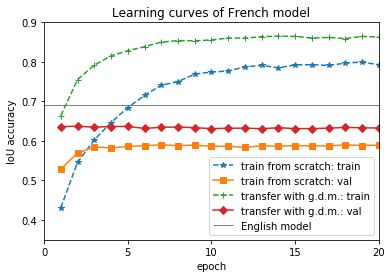

In [75]:
import matplotlib.pyplot as plt
plt.plot(epochs, train_iou_from_scratch, label='train from scratch: train', linestyle='--', marker='*')
plt.plot(epochs, val_iou_from_scratch, label='train from scratch: val', marker='s')
plt.plot(epochs, train_iou_general_dict_mapping, label='transfer with g.d.m.: train', linestyle='--', marker='+')
plt.plot(epochs, val_iou_general_dict_mapping, label='transfer with g.d.m.: val', marker='D')
plt.xlabel('epoch')
plt.ylabel('IoU accuracy')
plt.title('Learning curves of French model')
plt.xticks(range(0,21,5))
plt.ylim(0.35,0.9)
plt.xlim(0,20)
plt.hlines(y=0.69038, xmin=0, xmax=20, linewidth=0.5, label='English model')
plt.legend()

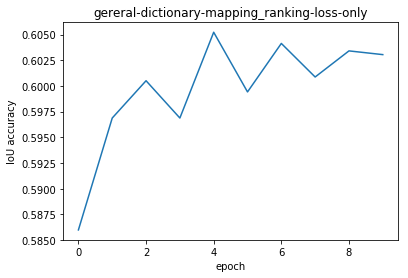

In [208]:
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('IoU accuracy')
plt.title('gereral-dictionary-mapping_ranking-loss-only')
plt.plot(loaded_process['val_IoU_acc_before_refinement'])


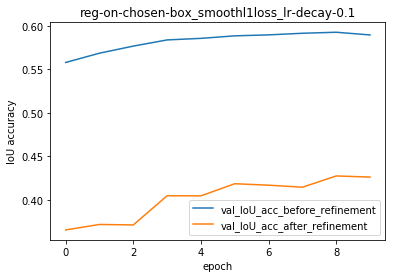

In [95]:
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('IoU accuracy')
plt.title('reg-on-chosen-box_smoothl1loss_lr-decay-0.1')
plt.plot(process['val_IoU_acc_before_refinement'], label='val_IoU_acc_before_refinement')
plt.plot(process['val_IoU_acc_after_refinement'], label='val_IoU_acc_after_refinement')
plt.legend()

## Test

In [132]:

model_test = DDPN(cfg, vocab_size=fr_vocab)

#model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
model_to_test_path = os.path.join(output_dir, "checkpoint_6.tar")
checkpoint = torch.load(model_to_test_path, map_location=device)
model_test.load_state_dict(checkpoint['model_state_dict'])

print("loaded checkpoint:", model_to_test_path)
model_test.to(device)


loaded checkpoint: /home/wenjian/Internship/DDPN_transfer/experiments/2019-08-09_10-46-31_3k_specific-dictionary-mapping_all-trainable-testing/checkpoint_6.tar


DDPN(
  (embedding): Embedding(2453, 300)
  (lstm): LSTM(300, 1024)
  (fc1): Linear(in_features=3077, out_features=512, bias=True)
  (fc_rank): Linear(in_features=512, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3)
  (softmax): Softmax()
)

In [133]:

# For statistics of IoU score
test_all_ious_original = []
if cfg.regression_loss:
    test_all_ious_refined = []
    
print(f"Evaluating on test set: {len(test_set)} samples" )
with torch.no_grad():      
    for test_batch_counter, (inputs, gt_bboxes, _) in enumerate(test_generator):
        Xs, queries = inputs
        #print("val_batch_counter", val_batch_counter)
        #print("Xs", Xs.size())
        #print("queries", len(queries))
        #print("gt_bboxes", gt_bboxes.size())

        Qs, seq_lengths = preprocess_query(queries)

        model_test.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        test_pred = model_test(Xs, Qs, seq_lengths)
        test_targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
#         try:
#             val_loss = loss_func(val_pred, val_targ)
#         except AssertionError as e:
#             print(f"epoch {epoch}, val, batch: {val_batch_counter}")
#             with open("debug.log", 'a') as log:
#                 log.write(f"epoch {epoch}, val, batch: {val_batch_counter}\n")
#             raise e
#         test_losses_by_epoch.append(val_loss.item())
#         val_loss_average_by_epoch += val_loss.item()*Xs.size(0)
        #logger.add_scalar('val_losses_all_batches', val_losses, val_batch_counter)

#         print(f"\repoch {epoch}, validation phase, batch {val_batch_counter}/{len(validation_generator)}, val_loss={val_loss.item()}", end='')
#         logger.add_scalar("val_loss_by_batch", val_loss.item(), val_batch_counter_total)

        # Statistics of IoU score
        if cfg.regression_loss:
            ious_original, ious_refined = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
        else:
            ious_original = calculate_IoU_scores(Xs, test_pred, gt_bboxes)
        test_all_ious_original = test_all_ious_original + ious_original.tolist()
        if cfg.regression_loss:
            test_all_ious_refined = test_all_ious_refined + ious_refined.tolist()
    
    good_original = torch.tensor(test_all_ious_original) > 0.5     
    print("Test set: good bounding box based on original bounding box:", good_original.sum().item())
    acc_original = good_original.sum().float()/len(test_set)
    print("Test set: accuracy based on original bounding box:", acc_original.item())

Evaluating on test set: 2789 samples
Test set: good bounding box based on original bounding box: 1785
Test set: accuracy based on original bounding box: 0.6400143504142761


In [33]:
import PIL
from PIL import Image, ImageDraw
import os

def draw_bounding_box(filepath_sourceimage, bbox, color, output_dir="", output_name=""):
    """
    Arguemnts:
        filepath: the path to the image file.
        bbox: a 4-element list to describe a bounding box; format: [x1,y1,x2,y2]
        color: a 3-element tuple or a string to describe a color. Example(pure red): (255,0,0) or "#ff0000" or "red"
    """
    img_name = os.path.basename(filepath_sourceimage)

    if isinstance(color, str):
        color = PIL.ImageColor.getrgb(color)

    img = Image.open(filepath_sourceimage).convert("RGBA")
    tmp = Image.new('RGBA', img.size, (0,0,0,0))
    draw = ImageDraw.Draw(tmp)
    draw.rectangle(bbox, fill=color+(32,), outline=color, width=2)
    img = Image.alpha_composite(img, tmp)
    img = img.convert("RGB") # Remove alpha for saving
    if output_name == "":
        out_img_name = 'bbox_' + img_name
    else:
        out_img_name = output_name
    output_path = os.path.join(output_dir, out_img_name)
    img.save(output_path)
    return output_path

In [34]:
def draw_multiple_bounding_boxes(filepath_sourceimage, bbox_color_tuple_list, output_dir="", output_name=""):
    """
    Arguemnts:
        filepath: the path to the image file.
        bbox_color_tuple_list: a list of (bbox, color) tuple, where
            bbox: a 4-element list to describe a bounding box; format: [x1,y1,x2,y2]
            color: a 3-element tuple or a string to describe a color. Example(pure red): (255,0,0) or "#ff0000" or "red"
    """
    img_name = os.path.basename(filepath_sourceimage)
    
    img = Image.open(filepath_sourceimage).convert("RGBA")
    
    
    for bbox, color in bbox_color_tuple_list:
        if isinstance(color, str):
            color = PIL.ImageColor.getrgb(color)
        tmp = Image.new('RGBA', img.size, (0,0,0,0))
        draw = ImageDraw.Draw(tmp)
        draw.rectangle(bbox, fill=color+(32,), outline=color, width=2)
        img = Image.alpha_composite(img, tmp)
        
    img = img.convert("RGB") # Remove alpha for saving
    if output_name == "":
        out_img_name = 'bbox_' + img_name
    else:
        out_img_name = output_name     
    output_path = os.path.join(output_dir, out_img_name)
    img.save(output_path)
    return output_path

In [89]:
# Separate this function from loss_wrapper to print two losses separately 
# Don't forget to synchronize this function when the loss_wrapper is modified
# Noted that no matter regularization loss is trained on chosen proposal or on all proposals, the loss in this function should always work on the chosen proposal. 
def loss_wrapper_testing(delta, epsilon):
    def my_loss(predict, target):  # predict is expected to be (s,t), target their ground truth value
        s, t = predict
        gt_s, gt_t = target
        #print("s", s.size())   # --> s torch.Size([64, 100])
        #print("gt_s", gt_s.size())   # --> gt_s torch.Size([64, 100])
        #print("t", t.size())   # --> t torch.Size([64, 100, 4])
        #print("gt_t", gt_t.size())   # --> gt_t torch.Size([64, 4])
        s = torch.add(s, torch.tensor(epsilon))  # In order to avoid 0 in the denominator
        try:
            assert not torch.isnan(s).any()
            assert not torch.isinf(s).any()
            assert not torch.isnan(t).any()
            assert not torch.isinf(t).any()
            assert not torch.isnan(gt_s).any()
            assert not torch.isinf(gt_s).any()
            assert not torch.isnan(gt_t).any()
            assert not torch.isinf(gt_t).any()
            loss_ranking = F.kl_div(torch.log(s), gt_s, reduction='batchmean') 
            assert not torch.isnan(loss_ranking).any()
            assert not torch.isinf(loss_ranking).any()
            N = t.size()[1]
            #print('gt_t after repeat', gt_t.unsqueeze(1).repeat(1,N,1).size())
            
            
            proposal_chosen = torch.argmax(s, dim=1)
            batch_size = s.size()[0]
            t_chosen = t[torch.arange(batch_size),proposal_chosen,:]  # t_chosen shape is expected to be (batch_size, 4)
            #print("t_chosen", t_chosen.size())
            loss_regression = F.smooth_l1_loss(t_chosen, gt_t, reduction='none')
            
            #loss_regression = F.smooth_l1_loss(t, gt_t.unsqueeze(1).repeat(1,N,1), reduction='mean')
            
            
            #print("loss_regression", loss_regression)
            assert not torch.isnan(loss_regression).any()
            assert not torch.isinf(loss_regression).any()
            
            print("ranking_loss", loss_ranking)
            print("regression_loss", loss_regression)
            #my_loss.counter += 1 
            
        except AssertionError as e:
            torch.set_printoptions(profile='full')
            print('s\n', s)
            print('t\n', t)
            print('gt_s\n', gt_s)
            print('gt_t\n', gt_t)
            with open("debug.log", 'w') as log:
                log.write('s\n')
                log.write(str(s))
                log.write('gt_s\n')
                log.write(str(gt_s))
            torch.set_printoptions(profile='default')
            raise e
           
        return delta*loss_ranking + torch.mean(loss_regression)  # Manual reduction
        #return loss_ranking + gamma*loss_regression
        #return loss_ranking 
    #my_loss.counter = 0
    return my_loss
loss_func_testing = loss_wrapper_testing(cfg.DELTA, cfg.epsilon)

In [35]:
phase = "test"

folder = "./test-visualization/"



if not os.path.exists(folder):
    os.mkdir(folder)

if phase == 'val':
    generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)
elif phase == 'test':
    generator_for_visualization = data.DataLoader(test_set, shuffle=False, batch_size=64)

    
model_test = DDPN(cfg, vocab_size=fr_vocab)

#model_en.load_state_dict(torch.load(english_pretrained_model_path, map_location=device))
model_to_test_path = os.path.join(output_dir, "checkpoint_1.tar")
checkpoint = torch.load(model_to_test_path, map_location=device)
model_test.load_state_dict(checkpoint['model_state_dict'])

model_test.to(device)




DDPN(
  (embedding): Embedding(2453, 300)
  (lstm): LSTM(300, 1024)
  (fc1): Linear(in_features=3077, out_features=512, bias=True)
  (fc_rank): Linear(in_features=512, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5)
  (softmax): Softmax()
)

In [39]:
len(generator_for_visualization)

44

In [47]:

print("loaded checkpoint:", model_to_test_path)


with torch.no_grad():
        
    batch_number = 15 # batch_number begins by 0, until last batch in the data set

    #for inputs, gt_bboxes in generator:
    it = iter(generator_for_visualization)
    for i in range(batch_number+1):
        inputs, gt_bboxes, IDs = next(it)
    Xs, queries = inputs
    img_ids, obj_ids, img_ws, img_hs = IDs
    #print("val_batch_counter", val_batch_counter)
    #print("Xs", Xs.size())
    #print("queries", len(queries))
    #print("gt_bboxes", gt_bboxes.size())

    Qs, seq_lengths = preprocess_query(queries)

    model_test.eval()

    Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

    pred = model_test(Xs, Qs, seq_lengths)
    targ = (get_softlable(Xs, gt_bboxes), gt_bboxes)
    #loss = loss_func_testing(pred, targ)
    loss = loss_func(pred, targ)
    print(loss.item())


    # Statistics of IoU score

    s, t = pred
    proposal_chosen = torch.argmax(s, dim=1)
    batch_size = Xs.size()[0]
    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
    #bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
    #print(bboxes_chosen.size())
    ious_original = IoU(bboxes_chosen_original, gt_bboxes).squeeze()  
    #ious_refined = IoU(bboxes_chosen_refined, gt_bboxes).squeeze() 
    
    
    def get_bbox_in_original_scale(boxes, img_ws, img_hs, sample_in_batch):
        box = boxes[sample_in_batch].tolist()[0]  # [0] is to remove a pair of []
        #print(box)
        #print(img_ws[sample_in_batch])
        #print(img_hs[sample_in_batch])
        #print(img_ws[sample_in_batch].data.cpu().numpy())
        box[0] *= img_ws[sample_in_batch].item()
        box[1] *= img_hs[sample_in_batch].item()
        box[2] *= img_ws[sample_in_batch].item()
        box[3] *= img_hs[sample_in_batch].item()
        #print("box[0]", box[0])
        return box
    
    for sample_in_batch in range(0,64): # Change here to see different samples

        gt_box = get_bbox_in_original_scale(gt_bboxes, img_ws, img_hs, sample_in_batch)
        top_rank_box = get_bbox_in_original_scale(bboxes_chosen_original, img_ws, img_hs, sample_in_batch)
        #refined_top_rank_box = get_bbox_in_original_scale(bboxes_chosen_refined, img_ws, img_hs, sample_in_batch)

#         boxes_colors = [(gt_box, "green"),
#                         (top_rank_box, "yellow"),
#                         (refined_top_rank_box, "red")
#                         ]

        boxes_colors = [(gt_box, "green"),
                        (top_rank_box, "yellow"),
                        ]

        img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
        query_number = batch_number*batch_size+sample_in_batch
        output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = folder,
                output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
        print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch], ious_original[sample_in_batch].item())

#os.system("xdg-open "+output_path)



loaded checkpoint: /home/wenjian/Internship/DDPN_transfer/experiments/2019-08-21_20-17-40_3k_all-trainable_general-dict-mapping_for-visualization/checkpoint_1.tar
1.2202752828598022
960 3107059919 94067 une petite fille 0.5595679879188538
961 3107059919 94069 bord d' une plage 0.8554666042327881
962 3128856481 95489 des ailes 0.9155943989753723
963 313385842 95785 deux hommes 0.37385568022727966
964 313385842 95782 l' arrière d' un camion 0.6198970079421997
965 313385842 95788 un objet métallique 0.44036829471588135
966 313385842 95790 quatre personnes 0.4853997230529785
967 3135317718 95915 une femme 0.6538425087928772
968 3135317718 95921 jupe rose 0.6377099752426147
969 3135317718 95916 un bébé 0.26449117064476013
970 3138504165 96038 un joueur de hockey 0.6490362286567688
971 3138504165 96040 maillot jaune 0.7010584473609924
972 3138504165 96042 le but 0.7251001000404358
973 314739483 96516 un homme 0.5830113291740417
974 314739483 96519 un grand panneau 0.6782522797584534
975 3148

In [ ]:
# This block is to draw all bounding box proposals on one image.  

visualization_dir = "./visualization_gt2/"


if not os.path.exists(visualization_dir):
    os.mkdir(visualization_dir)

validation_generator_for_visualization = data.DataLoader(validation_set, shuffle=False, batch_size=64)


batch_number = 1 # batch_number begins by 0, until last batch in validation set

#for inputs, gt_bboxes in validation_generator:
it = iter(validation_generator_for_visualization)
for i in range(batch_number+1):
    inputs, gt_bboxes, IDs = next(it)
Xs, queries = inputs
img_ids, obj_ids, img_ws, img_hs = IDs
#print("val_batch_counter", val_batch_counter)
#print("Xs", Xs.size())
#print("queries", len(queries))



def get_bbox_in_original_scale_all_proposals(boxes, img_ws, img_hs, sample_in_batch):
    #print(boxes)
    box = boxes.clone()
    #print(box[0])
    #print(img_ws[sample_in_batch])
    #print(img_hs[sample_in_batch])
    #print(img_ws[sample_in_batch].data.cpu().numpy())
    box[:,0] *= img_ws[sample_in_batch]
    box[:,1] *= img_hs[sample_in_batch]
    box[:,2] *= img_ws[sample_in_batch]
    box[:,3] *= img_hs[sample_in_batch]
    print("box", box)
    return box.tolist()

for sample_in_batch in range(0,64): # Change here to see a different sample

    sample_in_batch = 0

    proposals = Xs[sample_in_batch,:,-5:-1]
    proposal_list = get_bbox_in_original_scale_all_proposals(proposals, img_ws, img_hs, sample_in_batch)
    
     
    #print(proposal_list[0])
    
    img_path_source = os.path.join(img_dir, img_ids[sample_in_batch]+'.jpg')  
    im = Image.open(img_path_source)
    
    print(len(proposal_list[i]))
    
    for i in range(len(proposal_list)):
        ImageDraw.ImageDraw(im).rectangle(proposal_list[i], outline="yellow", width=0)
        
    query_number = batch_number*batch_size+sample_in_batch
#     output_path = draw_multiple_bounding_boxes(img_path_source, boxes_colors, output_dir = visualization_dir,
#             output_name=str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg')
    im.save(os.path.join(visualization_dir, str(query_number) + "_" + img_ids[sample_in_batch]+'_'+obj_ids[sample_in_batch]+'_'+queries[sample_in_batch]+'.jpg'))
    print(query_number, img_ids[sample_in_batch], obj_ids[sample_in_batch], queries[sample_in_batch])
    
    break

In [56]:
torch.isnan(torch.tensor([1,2]))

tensor([0, 0], dtype=torch.uint8)

In [100]:
Qs

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,   17,    0,    0,    0,
            0,    0,    0,   17,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,  130,  239,    0,    0,
            0,  239,    0,   31,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,   17,    0,    0,    0,    0,   71,
            0,    0,    0,    0,    0,    0,    0,    0,   17,    0,    0,    0,
           17,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,  186,  186,   17,    0,
            0,  186,    0,   30,   44,   

A blog on tips of deep learning debug

In [67]:
with open(pytorch_result_save_path+loss_filename, 'wb') as fp:
    pickle.dump(process, fp)

In [68]:
model.eval() # Do this before saving the model when dropout or batch normalization is involved. https://pytorch.org/tutorials/beginner/saving_loading_models.html
# Save model's learnable parameters
torch.save(model.state_dict(), pytorch_model_save_path+pth_filename)
# Save checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,

            }, pytorch_checkpoint_save_path+checkpoint_filename)

## output bounding box

In [32]:
# Load model
if False:
    if cfg.use_pretrained_word_embedding == None:
        model = DDPN(len(training_corpus_dct.token2id), cfg)
    elif cfg.use_pretrained_word_embedding == "GloVe":
        model = DDPN(len(training_corpus_dct.token2id), cfg, glove.vectors)
    model.load_state_dict(torch.load('/home/wenjian/Internship/DDPN_draft/model/ddpn.pth'))

AssertionError: Error: you are using non-pretraind embedding, and vocab_size is not an integer, but <__main__.CFG object at 0x7fb52806ee80>.

In [57]:

model.to(device)
model.eval()


with torch.no_grad():
    print(f"Evaluating the model on the validation set ({len(validation_set)} samples)...")
    all_ious_original = []
    all_ious_refined = []
    counter = 0
    for inputs, gt_bboxes in validation_generator:
        Xs, queries = inputs
        batch_size = Xs.size()[0]
        """
        indices = [training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)]) for q in queries]
        #print("---aaa---\n", indices)
        # Gensim assign -1 to unknown word in the dictionary. 
        # Pytorch embedding, however, don't support negative index. 
        # So we kept 1 for unknown word when building Gensim dictionary, and convert -1 to 1 now
        indices = [[idx if idx!=-1 else 1 for idx in row] for row in indices]
        #print("---bbb---\n", indices)

        Qs_before_padding = [torch.tensor(row) for row in indices]
        if cfg.use_pretrained_word_embedding == None:
            padding_value = 0
        elif cfg.use_pretrained_word_embedding == "GloVe":
            padding_value = 1  # 1 is '.', since in GloVe there is no empty word token
        #Qs = nn.utils.rnn.pad_sequence(Qs_before_padding, batch_first=False)
        Qs = pad_sequence_right_alignment(Qs_before_padding, batch_first=False, padding_value=padding_value)
        """
        Qs, seq_lengths = preprocess_query(queries)
        
        model.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        val_pred = model(Xs, Qs, seq_lengths)
        
        s, t = val_pred
        
        proposal_chosen = torch.argmax(s, dim=1)
        
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
#         bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
        #print(bboxes_chosen.size())
        ious_original = IoU(bboxes_chosen_original, gt_bboxes)  
#         ious_refined = IoU(bboxes_chosen_refined, gt_bboxes) 
        
        #print(ious.size())
        all_ious_original = all_ious_original + ious_original.squeeze().tolist()
#         all_ious_refined = all_ious_refined + ious_refined.squeeze().tolist()
        
        counter += 1
        #if counter%10 == 0:
        #    print(counter)

good_original = torch.tensor(all_ious_original) > 0.5     
print("good bounding box based on original bounding box:", good_original.sum())
acc_original = good_original.sum().float()/len(validation_set)
print("accuracy based on original bounding box:", acc_original)

# good_refined = torch.tensor(all_ious_refined) > 0.5
# print("good bounding box refined:", good_refined.sum())
# acc_refined = good_refined.sum().float()/len(validation_set)
# print("accuracy of refined bounding box:", acc_refined)

Evaluating the model on the validation set (14526 samples)...
good bounding box based on original bounding box: tensor(9112)
accuracy based on original bounding box: tensor(0.6273)


Without pretrained embedding:
With Wenjian's feature:
Epochs --> accuracy based on original bounding box --> accuracy of refined bounding box
3 epochs --> 20.30% --> 21.56% <br>
10 epochs --> 20.16% --> 21.70% <br>
20 epochs --> 18.88% --> 23.67%

With Otani's feature:
3 epochs --> 24.15% --> 19.12% <br>

Only consider ranking loss: <br>
3 epochs --> 57.83% (before considering multiple bounding boxes) <br>
3 epochs --> 62.73% (after considering multiple bounding boxes)

## Random selection test

In [141]:
import random
print(f"Evaluating the model on the validation set ({len(validation_set)} samples)...")
all_ious_original = []
all_ious_refined = []
counter = 0
random.seed()
for inputs, gt_bboxes in validation_generator:
    Xs, queries = inputs
    batch_size = Xs.size()[0]
    
    
    
    proposal_chosen = [random.randint(0,99) for i in range(100)]

    gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
    bboxes_chosen_original = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
    #print(bboxes_chosen.size())
    ious_original = IoU(bboxes_chosen_original, gt_bboxes)  

    #print(ious.size())
    all_ious_original = all_ious_original + ious_original.squeeze().tolist()

    counter += 1
    #if counter%10 == 0:
    #    print(counter)

good_original = torch.tensor(all_ious_original) > 0.5     
print("good bounding box based on original bounding box:", good_original.sum())
acc_original = good_original.sum().float()/len(validation_set)
print("accuracy based on original bounding box:", acc_original)


tensor(0.2028)


## Refined bounding box

In [142]:
with torch.no_grad():
    all_ious = []
    counter = 0
    for inputs, gt_bboxes in validation_generator:
        Xs, queries = inputs
        batch_size = Xs.size()[0]
        indices = [training_corpus_dct.doc2idx([stemmer.stem(w) for w in word_tokenize(q)]) for q in queries]
        #print("---aaa---\n", indices)
        # Gensim assign -1 to unknown word in the dictionary. 
        # Pytorch embedding, however, don't support negative index. 
        # So we kept 1 for unknown word when building Gensim dictionary, and convert -1 to 1 now
        indices = [[idx if idx!=-1 else 1 for idx in row] for row in indices]
        #print("---bbb---\n", indices)

        Qs_before_padding = [torch.tensor(row) for row in indices]
        Qs = nn.utils.rnn.pad_sequence(Qs_before_padding, batch_first=False)

        model.eval()

        Xs, Qs, gt_bboxes = Xs.to(device), Qs.to(device), gt_bboxes.to(device)

        val_pred = model(Xs, Qs)
        
        s, t = val_pred
        #print("t", t.size())
        
        proposal_chosen = torch.argmax(s, dim=1)
        
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen_refined = t[torch.arange(batch_size),proposal_chosen,:].unsqueeze(1)
        #print(bboxes_chosen.size())
        ious = IoU(bboxes_chosen_refined, gt_bboxes)  
        
        #print(ious.size())
        all_ious = all_ious + ious.squeeze().tolist()
        
        counter += 1
        print(counter)
        

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227


In [143]:
good_refined = torch.tensor(all_ious) > 0.5
print(good_refined.sum())

tensor(3132)


In [144]:
print(good_refined.sum().float()/len(validation_set))
# First try (3 epochs) --> 21.56%
# Second try (20 epochs) --> 23.67%

tensor(0.2156)


## Statistics on validation set

In [30]:
# Attention! this function only work on CPU. Relaod the oringal version after using this version
def intersect(box_a, box_b):  # Tackle with N (like 100) box pairs at the same time
    #print(box_a.type())
    #print(box_b.type())
    inter_xmin=torch.max(box_a[:,:,0], box_b[:,:,0])
    inter_xmax=torch.min(box_a[:,:,2], box_b[:,:,2])
    inter_ymin=torch.max(box_a[:,:,1], box_b[:,:,1])
    inter_ymax=torch.min(box_a[:,:,3], box_b[:,:,3])
    inter = torch.max((inter_xmax-inter_xmin).float(), torch.tensor(0).float().to('cpu')) * torch.max((inter_ymax-inter_ymin).float(), torch.tensor(0).float().to('cpu'))
    return inter
thre = 0.5
good_proposal = []
for i in range(len(validation_set)):
    iou = iou_pass_threshold(validation_set[i][0][0].unsqueeze(0),validation_set[i][1], thre)
    
    good_proposal.append(iou.sum())
    
    if i%100 == 0:
        print("i=", i, ", average=", np.array(good_proposal).mean())
#print("Finally,", counter, "examples pass the threshold.")

i= 0 , average= 1.0
i= 100 , average= 4.554455445544554
i= 200 , average= 4.3283582089552235
i= 300 , average= 4.212624584717608
i= 400 , average= 4.082294264339152
i= 500 , average= 4.06187624750499
i= 600 , average= 4.2579034941763725
i= 700 , average= 4.272467902995721
i= 800 , average= 4.253433208489389
i= 900 , average= 4.314095449500555
i= 1000 , average= 4.393606393606394
i= 1100 , average= 4.464123524069028
i= 1200 , average= 4.385512073272273
i= 1300 , average= 4.467332820906995
i= 1400 , average= 4.599571734475375
i= 1500 , average= 4.574950033311126
i= 1600 , average= 4.553404122423485
i= 1700 , average= 4.577895355673133
i= 1800 , average= 4.520821765685731
i= 1900 , average= 4.52656496580747
i= 2000 , average= 4.491754122938531
i= 2100 , average= 4.488338886244645
i= 2200 , average= 4.534756928668787
i= 2300 , average= 4.515428074750108
i= 2400 , average= 4.555601832569763
i= 2500 , average= 4.591363454618152
i= 2600 , average= 4.549404075355633
i= 2700 , average= 4.611625

In [121]:
4.04/76.5  # There are 76.5 proposals per image on average for the whole Flickr30k dataset. 

0.05281045751633987

In [ ]:
with torch.no_grad():
    all_ious = []
    counter = 0
    for inputs, gt_bboxes in validation_generator:
        Xs, queries = inputs
        batch_size = Xs.size()[0]
        
        
        
        
        
        
        gt_bboxes = gt_bboxes.unsqueeze(1) # add a dimension 1 at the middle is to use the function IoU
        bboxes_chosen = Xs[torch.arange(batch_size),proposal_chosen,-5:-1].unsqueeze(1)
        #print(bboxes_chosen.size())
        ious = IoU(bboxes_chosen, gt_bboxes)  
        
        #print(ious.size())
        all_ious = all_ious + ious.squeeze().tolist()
        
        counter += 1
        print(counter)
        

## Utilities: for obtaining the general dictionary by google translation

In [27]:
with open(f"./dictionary/FrenchWordList{fr_dataset_volume}.txt", "w") as f:
    for key in training_corpus_dct.token2id:
        f.write(key+'\n')

In [29]:
with open(f"./dictionary/FrenchWordList{fr_dataset_volume}.txt", "r") as f_fr:
    fr_words = f_fr.readlines()
    fr_words = [item.strip() for item in fr_words]  
with open(f"./dictionary/Fr-En-GoogleTrans{fr_dataset_volume}.txt", "r") as f_en:
    en_words = f_en.readlines()
    en_words = [item.strip() for item in en_words]  
    en_words = [item.split(' ')[-1] for item in en_words]  # When it is a phrase, just choose the last word
with open(f"./dictionary/Fr-En-GoogleTrans_dictionary{fr_dataset_volume}.txt", "w") as f_fr2en:
    for i in range(len(fr_words)):
        f_fr2en.write(f"{fr_words[i]} {en_words[i]}\n") 

## Random tests

In [44]:
torch.tensor([3,5]).float() / torch.tensor(4)

tensor([0.7500, 1.2500])

In [69]:
a = torch.tensor([[1,2,3],[4,5,6]])

In [72]:
torch.argmax(a, dim=1)

tensor([2, 2])

In [95]:
a>1.5

tensor([[0, 1, 1],
        [1, 1, 1]], dtype=torch.uint8)

In [97]:
a*(a>1.5).long()

tensor([[0, 2, 3],
        [4, 5, 6]])

In [22]:
a = np.array([[1,2],[3,4]])

In [24]:
a.tolist()

[[1, 2], [3, 4]]

In [25]:
a[:,0]

array([1, 3])

In [79]:
a = np.array((1,2,3))
b = np.array((4,5,6))
c = np.array((7,8,9))
d = np.array((10,11,12))

In [80]:
A = np.column_stack((a,b))
B = np.column_stack((c,d))

In [81]:
AB = np.column_stack((A,B))

In [82]:
ABA = np.column_stack((AB,A))

In [83]:
ABA

array([[ 1,  4,  7, 10,  1,  4],
       [ 2,  5,  8, 11,  2,  5],
       [ 3,  6,  9, 12,  3,  6]])

In [87]:
ABA[[1,2,3],[1,2,3]]

IndexError: index 3 is out of bounds for axis 0 with size 3

In [88]:
x = np.array([[0,1,2],[3,4,5],[6,7,8],[9,10,11],[12,13,14],[15,16,17]])

In [92]:
x = torch.from_numpy(x)

In [93]:
x

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])

In [90]:
y = np.array([0,2,1,0,2,0])
y = torch.from_numpy(y)

In [94]:
x[torch.arange(6), y]

tensor([ 0,  5,  7,  9, 14, 15])

In [41]:
np.stack((AB,A), axis=1)

ValueError: all input arrays must have the same shape

In [88]:
class ManglingTest:
    def __init__(self):
        self.__mangled = 'hello'

    def get_mangled(self):
        return self.__mangled

ManglingTest().get_mangled()


'hello'

In [90]:
ManglingTest().__mangled()

AttributeError: ManglingTest instance has no attribute '__mangled'

In [109]:
x = torch.tensor([1, 2, 3])
x.repeat((4,1))


tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [102]:
x.repeat(4, 2).size()

torch.Size([4, 6])

In [104]:
x.repeat(4, 2, 1)

tensor([[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]])

In [103]:
x.repeat(4, 2, 1).size()


torch.Size([4, 2, 3])

In [120]:
C.a=1

NameError: name 'C' is not defined

In [129]:
def myfunc():
    a = 1
    b = 2
    c = 3
    return (a,b), c
d,e,f = myfunc()
d

ValueError: need more than 2 values to unpack

In [127]:
e

3

In [43]:
a = torch.tensor([[1,2],[3,4]])
b = a.repeat(1,2,1)

In [44]:
b

tensor([[[1, 2],
         [3, 4],
         [1, 2],
         [3, 4]]])

In [46]:
b.size()[1]

4

In [ ]:
import visdom

In [ ]:
vis = visdom.Visdom()

In [1]:
10/15

0.6666666666666666

## GPU

In [1]:
import torch
torch.cuda.device_count()

1

In [16]:
torch.cuda.get_device_name('cuda:0')

'GeForce GTX 1080 Ti'

In [19]:
type(torch.device(0))

torch.device

In [3]:
torch.cuda.current_device()

0

In [9]:
torch.cuda.get_device_capability(device=0)

(6, 1)

In [10]:
torch.cuda.get_device_name(device=0)

'GeForce GTX 1080 Ti'

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.cuda.max_memory_allocated(device=0)

0

In [13]:
torch.cuda.memory_allocated(device=0)

0

In [14]:
torch.cuda.memory_cached(device=0)

0

In [117]:
a = torch.tensor([[1,2],[3,4]])

In [118]:
a.to(0)

tensor([[1, 2],
        [3, 4]], device='cuda:0')

In [119]:
a.get_device()

-1

In [66]:
a.to('cpu')

tensor([[1, 2],
        [3, 4]])

In [65]:
a.to('cuda:0')

tensor([[1, 2],
        [3, 4]], device='cuda:0')

## Tensorboard

In [3]:
import torch
from torch.utils.tensorboard import SummaryWriter

ImportError: TensorBoard logging requires TensorBoard with Python summary writer installed. This should be available in 1.14 or above.

In [4]:
torch.__version__

'1.1.0'

In [7]:
! pip3 install -U torch

  Using cached https://files.pythonhosted.org/packages/69/60/f685fb2cfb3088736bafbc9bdbb455327bdc8906b606da9c9a81bae1c81e/torch-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/87/2d/e4656149cbadd3a8a0369fcd1a9c7d61cc7b87b3903b85389c70c989a696/numpy-1.16.4-cp36-cp36m-manylinux1_x86_64.whl


In [1]:
import tensorflow

In [1]:
from tensorboardX import SummaryWriter

In [8]:
import gensim
m = gensim.models.KeyedVectors.load_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', binary=True)  

In [9]:
m.__dir__()

['vectors',
 'vocab',
 'vector_size',
 'index2word',
 'vectors_norm',
 '__module__',
 '__doc__',
 'save_word2vec_format',
 'load_word2vec_format',
 'get_keras_embedding',
 'load',
 '__init__',
 'wv',
 'index2entity',
 'syn0',
 'syn0norm',
 '__contains__',
 'save',
 'word_vec',
 'get_vector',
 'words_closer_than',
 'most_similar',
 'similar_by_word',
 'similar_by_vector',
 'similarity_matrix',
 'wmdistance',
 'most_similar_cosmul',
 'doesnt_match',
 'cosine_similarities',
 'distances',
 'distance',
 'similarity',
 'n_similarity',
 '_log_evaluate_word_analogies',
 'evaluate_word_analogies',
 'log_accuracy',
 'accuracy',
 'log_evaluate_word_pairs',
 'evaluate_word_pairs',
 'init_sims',
 'relative_cosine_similarity',
 'add',
 '__setitem__',
 '__getitem__',
 'most_similar_to_given',
 'closer_than',
 'rank',
 '_load_specials',
 '_adapt_by_suffix',
 '_smart_save',
 '_save_specials',
 '__dict__',
 '__weakref__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__del

In [2]:
def my_gen():
    for i in range(5):
        yield i

In [3]:
print(my_gen())

<generator object my_gen at 0x7efc78480150>


In [96]:
a = torch.tensor([[0,0,0],[0,0,0]]).float()

In [97]:
torch.nn.init.xavier_uniform_(a)

tensor([[ 0.3895,  0.0679, -0.1960],
        [ 0.2881, -0.3075,  0.6298]])